# Toy Distributions for L2HMC

## Setup

### Imports

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Global imports
import sys
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import horovod.tensorflow as hvd
hvd.init()

from collections import namedtuple

# append parent directory to `sys.path`
# to load from modules in `../l2hmc-qcd/`
module_path = os.path.join('..')
if module_path not in sys.path:
    sys.path.append(module_path)

# Local imports
from utils.attr_dict import AttrDict
from utils.training_utils import train_dynamics
from dynamics.config import DynamicsConfig
from dynamics.base_dynamics import BaseDynamics
from dynamics.generic_dynamics import GenericDynamics
from network.config import LearningRateConfig
from config import (State, NetWeights, MonteCarloStates,
                    BASE_DIR, BIN_DIR, TF_FLOAT)

from utils.distributions import (plot_samples2D, contour_potential,
                                 two_moons_potential, sin_potential,
                                 sin_potential1, sin_potential2)

#sns.set_palette('bright')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
sns.set(context="notebook")
plt.style.use("/Users/saforem2/.config/matplotlib/stylelib/molokai.mplstyle")

## Helper functions

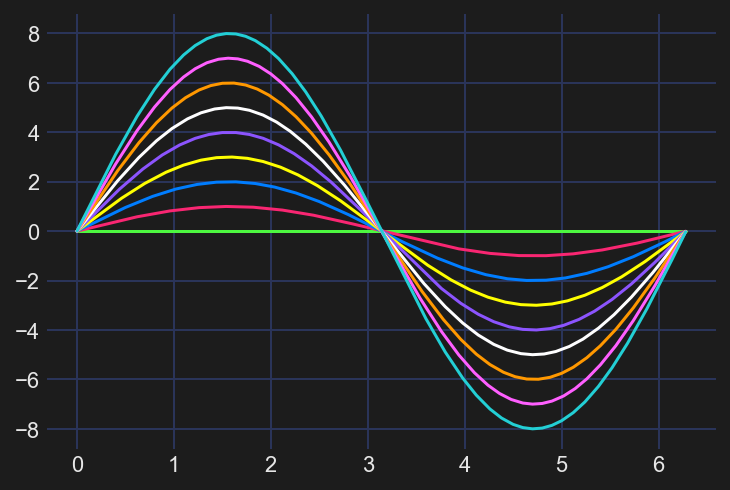

In [5]:
x = np.arange(0, 2*np.pi, 0.02)
y_arr = [i * np.sin(x) for i in range(9)]
fig, ax = plt.subplots()
for y in y_arr:
    _ = ax.plot(x, y)

In [7]:
from network.config import NetworkConfig, LearningRateConfig

def identity(x):
    return x

def get_dynamics(flags):
    """Return `GenericDynamics` object, initialized from `flags`."""
    config = DynamicsConfig(eps=flags.eps,
                            num_steps=flags.num_steps,
                            aux_weight=flags.aux_weight,
                            loss_scale=0.1,
                            hmc=flags.hmc,
                            eps_fixed=flags.eps_fixed,
                            model_type=flags.model_type)


    net_config = NetworkConfig(units=flags.units,
                               dropout_prob=flags.dropout_prob,
                               name=flags.network_name,
                               activation_fn=flags.activation_fn)

    lr_config = LearningRateConfig(flags.lr_init,
                                   decay_steps=flags.decay_steps,
                                   decay_rate=flags.decay_rate,
                                   warmup_steps=flags.warmup_steps)

    dynamics = GenericDynamics(params=flags,
                               config=config,
                               lr_config=lr_config,
                               normalizer=identity,
                               network_config=net_config,
                               potential_fn=POTENTIAL_FN,
                               name=MODEL_TYPE)
    
    return dynamics

In [8]:
import utils.file_io as io
from utils.distributions import contour_potential

#%matplotlib inline

def plot_chains(dirs, x_arr, potential_fn, label=None, cmap='rainbow'):
    figs_dir = os.path.join(dirs.log_dir, 'figures')
    io.check_else_make_dir(figs_dir)

    x_arr = tf.convert_to_tensor(x_arr).numpy()

    for chain in range(4):
        fig, ax = plt.subplots()
        xy = np.array((x_arr[1000:, chain, 0], x_arr[1000:, chain, 1]))
        #sns.kdeplot(*xy, ax=ax)
        #grid = xy.reshape(2, -1).T
        #Z = np.exp(-POTENTIAL_FN(grid))
        #_ = ax.contourf(xy[0], xy[1], Z.reshape(xy[0].shape, xy[1].shape), cmap='inferno')
        #xlim = np.abs(np.floor(np.min(xy[0]))) + 1
        #ylim = np.abs(np.floor(np.max(xy[1]))) + 1
        xlim = 5
        ylim = 5
        _ = contour_potential(POTENTIAL_FN, ax=ax, cmap=cmap, xlim=xlim, ylim=ylim)
        _ = ax.plot(*xy, alpha=0.3, mew=0.9, ls='', marker='+',
                    color='white', label='l2hmc samples')
        #_ = ax.legend(markerscale=5., loc='best')
        _ = ax.set_xlim((-xlim, xlim))
        _ = ax.set_ylim((-ylim, ylim))
        out_file = os.path.join(figs_dir, f'trained_samples_chain{chain}.png')
        print(f'Saving figure to: {out_file}')
        _ = plt.savefig(out_file, dpi=400, bbox_inches='tight')
        plt.show()

In [9]:
def plot_density_estimation(potential_fn, x_l2hmc, x_hmc,
                            title=None, cmap=None, num_plots=5):
    def _format_arr(x):
        x = np.array(x)
        n = x.shape[0]
        therm = 2 * n // 10  # Drop first 20% of samples (thermalization)
        return x[therm:]
    
    x_l2hmc = _format_arr(x_l2hmc)
    x_hmc = _format_arr(x_hmc)
    
    for idx in range(num_plots):
        fig, axes = plt.subplots(ncols=3, figsize=(12, 4))
        _ = contour_potential(potential_fn, title=title, ax=axes[0], cmap=cmap)
        _ = sns.kdeplot(x_l2hmc[:, idx, 0], x_l2hmc[:, idx, 1],
                        shade=True, cmap=cmap, ax=axes[1])
        _ = sns.kdeplot(x_hmc[:, idx, 0], x_hmc[:, idx, 1],
                        shade=True, cmap=cmap, ax=axes[2])
        _ = axes[1].set_title('L2HMC samples')
        _ = axes[2].set_title('HMC samples')
        plt.tight_layout()
        
    return fig, axes

### Plot examples of (toy) target distributions:

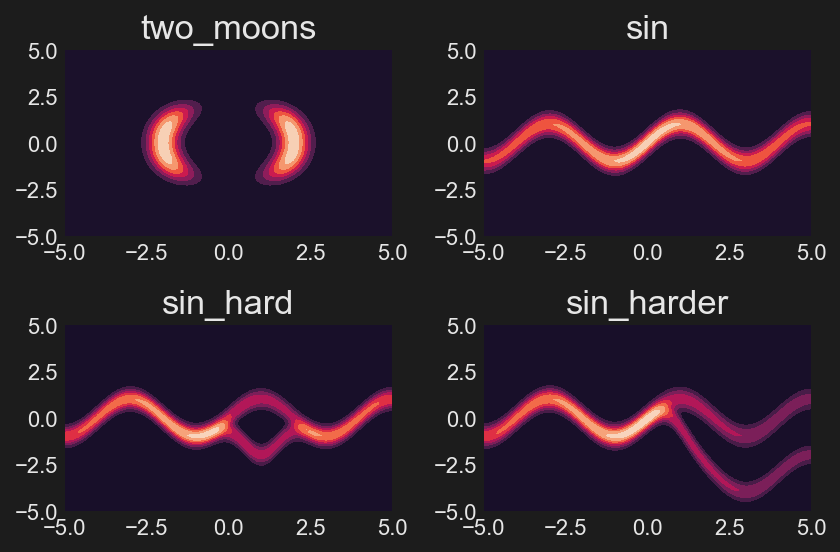

In [10]:
fig, axes = plt.subplots(nrows=2, ncols=2)
axes = axes.flatten()
names = ['two_moons', 'sin', 'sin_hard', 'sin_harder']
potentials = [two_moons_potential, sin_potential, sin_potential1, sin_potential2]
potentials_and_axes = zip(potentials, axes)
potentials_dict = {}
for idx, (p_fn, ax) in enumerate(zip(potentials, axes)):
    _ = contour_potential(p_fn, ax, title=f'{names[idx]}', cmap='rocket')
    ax.facecolor = '#1c1c1c'
    fig = plt.gcf()
    fig.facecolor = '#1c1c1c'
    potentials_dict[names[idx]] = p_fn
    

plt.grid(True)
plt.show()

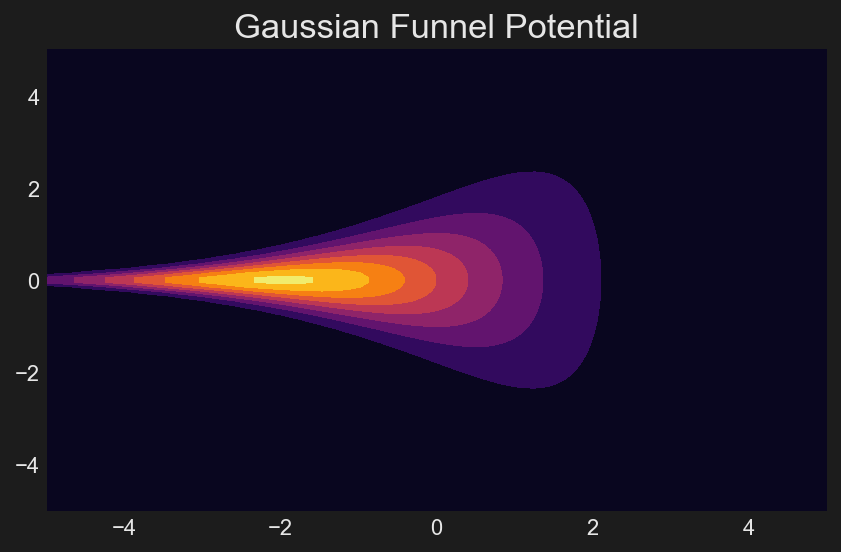

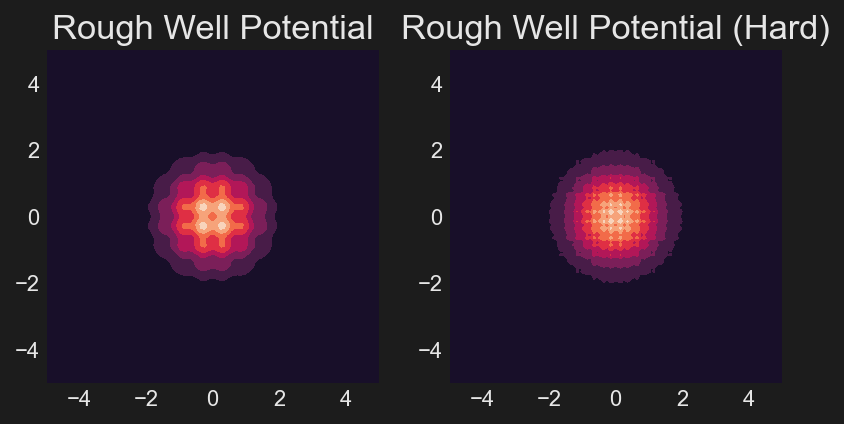

In [11]:
from utils.distributions import GaussianFunnel, RoughWell

funnel = GaussianFunnel()
funnel_potential = funnel.get_energy_function()
fig, ax = plt.subplots()
_ = contour_potential(funnel_potential, ax=ax, title=f'Gaussian Funnel Potential')
plt.show()

rough_well = RoughWell(dim=2, eps=0.1, easy=True)
rough_well_hard = RoughWell(dim=2, eps=0.1, easy=False)

rw_potential = rough_well.get_energy_function()
rwh_potential = rough_well_hard.get_energy_function()

fig, axes = plt.subplots(nrows=1, ncols=2)
axes = axes.flatten()
ax0 = contour_potential(rw_potential, ax=axes[0], cmap='rocket', title='Rough Well Potential')
ax1 = contour_potential(rwh_potential, ax=axes[1], cmap='rocket', title='Rough Well Potential (Hard)')
ax0.set_aspect('equal')
ax1.set_aspect('equal')

potentials_dict.update({
    'funnel': funnel_potential,
    'rough_well': rw_potential,
    'rough_well_hard': rwh_potential,
})

In [12]:
from utils.distributions import GaussianMixtureModel, meshgrid
import tensorflow_probability as tfp

tfd = tfp.distributions
floatx = tf.keras.backend.floatx()


def make_gmm_model(mus, sigmas, pis):
    def to_tensors(x):
        return (tf.convert_to_tensor(i, dtype=floatx) for i in x)
    
    mus, sigmas, pis = to_tensors([mus, sigmas, pis])
    gmm = tfd.Mixture(
        cat=tfd.Categorical(probs=pis),
        components=[
            tfd.MultivariateNormalDiag(loc=m, scale_diag=s)
            for m, s in zip(mus, sigmas)
        ]
    )
    
    def potential(x):
        return -1. * gmm.log_prob(x)
    
    #model = GaussianMixtureModel(mus, sigmas, pis) 
    #potential_fn = lambda x: -1. * model.dist.log_prob(x)
    #return model, potential_fn
    
    return gmm, potential

Gaussian mixture models:

 1. 2-Component mixture: 
 $$x \sim p(x) \equiv \frac{1}{2}\mathcal{N}(\vec{x}_{0}, \Sigma_{0}) + \frac{1}{2}\mathcal{N}(\vec{x}_{1}, \Sigma_{1})$$
 2. $4\times 4$ Lattice of Gaussians: 
 $$x\sim\mathcal{N}(\vec{x}_{ij}, \Sigma_{ij})$$

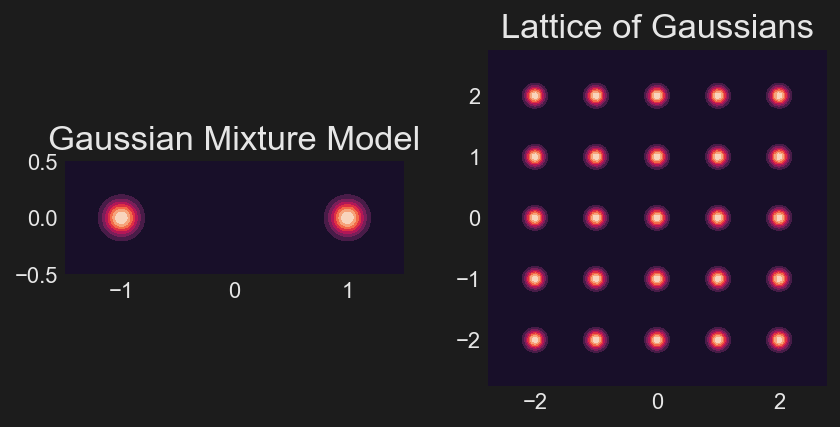

In [18]:
# ==== Mixture of two components
mus = [(-1., 0), (1., 0)]
sigmas = [0.1 * np.ones(2) for _ in range(len(mus))]
pis = len(mus) * [1. / len(mus)]

gmm, gmm_potential = make_gmm_model(mus, sigmas, pis)


# ==== 4x4 Lattice of Gaussians
# xy locations of each component
mus = [(-2, -2), (-2, -1), (-2, +0), (-2, +1), (-2, +2),
       (-1, -2), (-1, -1), (-1, +0), (-1, +1), (-1, +2),
       (+0, -2), (+0, -1), (+0, +0), (+0, +1), (+0, +2),
       (+1, -2), (+1, -1), (+1, +0), (+1, +1), (+1, +2),
       (+2, -2), (+2, -1), (+2, +0), (+2, +1), (+2, +2)]

sigmas = [0.1 * np.ones(2) for _ in range(len(mus))]
pis = len(mus) * [1. / len(mus)]

gmm_latt, gmm_latt_potential = make_gmm_model(mus, sigmas, pis)


potentials_dict.update({
    'gmm': gmm_potential,
    'lattice_of_gaussians': gmm_latt_potential,
})


# ==== Plot contours of both potentials
fig, axes = plt.subplots(ncols=2)
axes = axes.flatten()

ax0 = contour_potential(gmm_potential, ax=axes[0],
                        cmap='rocket', xlim=1.5, ylim=0.5,
                        title='Gaussian Mixture Model')

ax1 = contour_potential(gmm_latt_potential, ax=axes[1],
                        cmap='rocket', xlim=2.7777775, ylim=2.75,
                        title='Lattice of Gaussians')
    
_ = [ax.set_aspect('equal') for ax in axes]

## Define parameters of the model and target distribution

In [19]:
import utils.file_io as io
import datetime

LOGS_DIR = os.path.abspath('../../logs')

# DEFINE THE TARGET DISTRIBUTION
MODEL_TYPE = 'gmm'
POTENTIAL_FN = potentials_dict[MODEL_TYPE]

now = datetime.datetime.now()
date_str = now.strftime('%Y-%m-%d')
timestamp = now.strftime('%Y-%m-%d-%H%M%S')

log_dir = os.path.join(LOGS_DIR, f'{MODEL_TYPE}', date_str)
if os.path.isdir(log_dir):
    log_dir = os.path.join(log_dir, timestamp)
    
io.check_else_make_dir(log_dir)


flags = AttrDict({
    'profiler': False,
    'xdim': 2,
    'eps': 0.01,
    'aux_weight': 0.,
    'loss_scale': 0.1,
    'batch_size': 256,
    'num_steps': 10,
    'beta_init': 0.01,
    'beta_final': 1.,
    'compile': True,
    'hmc_steps': 0,
    'lr_init': 1e-3,
    'train_steps': 5000,
    'clip_val': 1.0,
    'decay_rate': 0.96,
    'save_steps': 1000,
    'logging_steps': 10,
    'warmup_steps': 1000,
    'print_steps': 1,
    'units': [128, 128],
    'hmc': False,
    'eps_fixed': False,
    'model_type': MODEL_TYPE,
    'network_name': 'GenericNetwork',
    'dropout_prob': 0.,
    'activation_fn': tf.nn.relu,
    'log_dir': log_dir,
})

flags.decay_steps = flags.train_steps // 5
#flags.warmup_steps = flags.train_steps // 10

2020-09-28 17:13:11,809:INFO:Creating directory: /Users/saforem2/l2hmc-qcd/logs/gmm/2020-09-28/2020-09-28-171311


## Train

### Start by training HMC to find optimal step-size $\varepsilon$ and thermalized config $x_{\mathrm{therm}}$ 

In [21]:
from network.config import NetworkConfig, LearningRateConfig

flags.hmc_steps = 1000
flags.restore = False

x_shape = (flags.batch_size, flags.xdim)
x = tf.random.normal(shape=x_shape, dtype=TF_FLOAT)

net_config = NetworkConfig(units=flags.units,
                           dropout_prob=flags.dropout_prob,
                           name=flags.network_name,
                           activation_fn=flags.activation_fn)

lr_config = LearningRateConfig(flags.lr_init,
                     decay_steps=flags.decay_steps,
                     decay_rate=flags.decay_rate,
                     warmup_steps=flags.warmup_steps)

# TRAIN HMC
if flags.hmc_steps > 0:
    hmc_flags = AttrDict({k: v for k, v in flags.items()})
    #hmc_flags.train_steps = hmc_flags.pop('hmc_steps')
    hmc_flags.train_steps = 5000
    hmc_flags.logging_steps = hmc_flags.train_steps // 20
    hmc_flags.beta_final = hmc_flags.beta_init
    hmc_flags.compile = True
    hmc_config = DynamicsConfig(eps=hmc_flags.eps,
                                num_steps=hmc_flags.num_steps,
                                hmc=True,
                                eps_fixed=flags.eps_fixed,
                                model_type=MODEL_TYPE)
    hmc_dynamics = GenericDynamics(params=hmc_flags,
                                   config=hmc_config,
                                   lr_config=lr_config,
                                   network_config=net_config,
                                   potential_fn=POTENTIAL_FN,
                                   name=MODEL_TYPE)
    hmc_dirs = io.setup_directories(hmc_flags, 'training_hmc')
    x, train_data = train_dynamics(hmc_dynamics, hmc_flags, dirs=hmc_dirs, x=x)
    
    output_dir = os.path.join(hmc_dirs.train_dir, 'outputs')
    train_data.save_data(output_dir)
    #flags.eps = hmc_dynamics.eps.numpy()

2020-09-28 17:13:47,870:INFO:Saving FLAGS to /Users/saforem2/l2hmc-qcd/logs/gmm/2020-09-28/2020-09-28-171311/training_hmc/FLAGS.z.
2020-09-28 17:13:48,526:INFO:************************************************************************************************************************
2020-09-28 17:14:04,121:INFO:Compiled `dynamics.train_step` using tf.function!
2020-09-28 17:14:04,122:INFO:************************************************************************************************************************


------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
     0/5000     0.01806      208.3         1        0.01002       0.01         0      
     1/5000     0.01691      298.6         1        0.01003       0.01         0      
     2/5000     0.01756      318.9         1        0.01005       0.01         0      
     3/5000     0.01652      194.8         1        0.01006       0.01         0      
     4/5000     0.01664      187.4         1        0.01007       0.01         0      
     5/5000     0.01811      334.1         1        0.01009       0.01         0      
     6/5000      0.017       247.7         1        0.01011       0.01         0      
     7/5000     0.01777      246.7         1        0.01012       0.01         0      
     8/5000     0.01684      230.1         1     

    94/5000     0.01767      161.7         1        0.01436       0.01         0      
    95/5000     0.01747      126.2         1        0.01443       0.01         0      
    96/5000     0.01693      105.2         1        0.01449       0.01         0      
    97/5000     0.01752      109.6         1        0.01456       0.01         0      
    98/5000     0.01775       122          1        0.01462       0.01         0      
    99/5000     0.01757       115          1        0.01469       0.01         0      
------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
   100/5000     0.01771       141          1        0.01475       0.01         0      
   101/5000     0.01781      187.7         1        0.01482       0.01         0      
   102/5000     0.01709      98.09         1     

   188/5000      0.0185       60.3       0.9999     0.02048       0.01         0      
   189/5000     0.01893      77.16       0.9999     0.02055       0.01         0      
   190/5000     0.01849      59.71       0.9999     0.02061       0.01         0      
   191/5000     0.01873      86.07         1        0.02066       0.01         0      
   192/5000     0.01972      59.53         1        0.02072       0.01         0      
   193/5000      0.019       84.04         1        0.02078       0.01         0      
   194/5000      0.0182       90.6         1        0.02084       0.01         0      
   195/5000     0.01886      52.89         1         0.0209       0.01         0      
   196/5000     0.01816      80.39         1        0.02096       0.01         0      
   197/5000     0.01832      76.68       0.9999     0.02103       0.01         0      
   198/5000     0.01821      55.22       0.9997     0.02109       0.01         0      
   199/5000     0.01816      79.27         

   278/5000     0.01854      32.31       0.9996      0.0256       0.01         0      
   279/5000     0.01835      39.52       0.9999     0.02565       0.01         0      
   280/5000     0.01875      72.36       0.9998      0.0257       0.01         0      
   281/5000     0.01849      66.21       0.9999     0.02576       0.01         0      
   282/5000     0.01983      31.78       0.9999     0.02582       0.01         0      
   283/5000     0.01883      42.01       0.9999     0.02587       0.01         0      
   284/5000     0.01866      72.74       0.9998     0.02592       0.01         0      
   285/5000     0.01944      58.35       0.9999     0.02597       0.01         0      
   286/5000     0.01818      104.1       0.9999     0.02603       0.01         0      
   287/5000      0.0189      51.36       0.9999     0.02608       0.01         0      
   288/5000     0.01858      59.56       0.9999     0.02614       0.01         0      
   289/5000     0.01895      91.62       0.

   374/5000     0.02104      61.06       0.9998     0.03091       0.01         0      
   375/5000     0.01918      26.31       0.9999     0.03097       0.01         0      
   376/5000      0.0198      61.97       0.9997     0.03105       0.01         0      
   377/5000     0.02093      36.65       0.9999     0.03112       0.01         0      
   378/5000     0.02013      64.57       0.9996      0.0312       0.01         0      
   379/5000     0.02019      29.84       0.9999     0.03128       0.01         0      
   380/5000     0.01955      23.63       0.9998     0.03136       0.01         0      
   381/5000     0.01962      34.54       0.9998     0.03143       0.01         0      
   382/5000     0.02031      22.47       0.9998      0.0315       0.01         0      
   383/5000     0.01994      20.02       0.9998     0.03157       0.01         0      
   384/5000     0.01978      26.69       0.9999     0.03164       0.01         0      
   385/5000     0.01967      31.57       0.

   469/5000     0.02194      19.74       0.9995     0.03649       0.01         0      
   470/5000     0.02006      15.91       0.9997     0.03656       0.01         0      
   471/5000     0.02189       36.1       0.9995     0.03663       0.01         0      
   472/5000     0.02075      47.32       0.9995     0.03667       0.01         0      
   473/5000     0.02101      23.91       0.9997     0.03671       0.01         0      
   474/5000     0.02121      20.72       0.9998     0.03675       0.01         0      
   475/5000     0.02026      44.76       0.9994     0.03679       0.01         0      
   476/5000     0.02027      32.83       0.9997     0.03685       0.01         0      
   477/5000     0.02136      21.27       0.9996      0.0369       0.01         0      
   478/5000     0.01994      22.84       0.9999     0.03695       0.01         0      
   479/5000     0.02037      18.48       0.9998      0.037        0.01         0      
   480/5000     0.02146      26.72       0.

   559/5000     0.02279      37.02       0.9995     0.04102       0.01         0      
   560/5000     0.02257      21.02       0.9997     0.04111       0.01         0      
   561/5000     0.02216      10.97       0.9998     0.04118       0.01         0      
   562/5000     0.02194       10.9       0.9997     0.04125       0.01         0      
   563/5000     0.02156      21.02       0.9999     0.04132       0.01         0      
   564/5000     0.02103      22.44       0.9994     0.04138       0.01         0      
   565/5000     0.02062      26.59       0.9998     0.04145       0.01         0      
   566/5000     0.02138      22.91       0.9995     0.04152       0.01         0      
   567/5000     0.02229       26.8       0.9996      0.0416       0.01         0      
   568/5000     0.02206      24.68       0.9995     0.04166       0.01         0      
   569/5000     0.02174      34.19       0.9997     0.04174       0.01         0      
   570/5000     0.02298      18.04       0.

   657/5000     0.02256       19.3       0.9998     0.04681       0.01         0      
   658/5000     0.02182       37.6       0.9995     0.04686       0.01         0      
   659/5000     0.02179      9.696       0.9995      0.0469       0.01         0      
   660/5000     0.02161      17.98       0.9993     0.04695       0.01         0      
   661/5000     0.02145      9.973       0.9998     0.04699       0.01         0      
   662/5000     0.02165      29.21       0.9996     0.04704       0.01         0      
   663/5000     0.02204      14.77       0.9992      0.0471       0.01         0      
   664/5000     0.02279      21.87       0.9998     0.04716       0.01         0      
   665/5000     0.02306      50.54       0.9994     0.04723       0.01         0      
   666/5000     0.02411      21.98       0.9997     0.04731       0.01         0      
   667/5000     0.02285      12.19       0.9991     0.04737       0.01         0      
   668/5000     0.02463      8.105       0.

   749/5000     0.02308       48.1       0.9992     0.05099       0.01         0      
------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
   750/5000     0.02239      9.697       0.9994     0.05099       0.01         0      
   751/5000     0.02284      17.43       0.9994      0.051        0.01         0      
   752/5000     0.02277      9.388       0.9996     0.05101       0.01         0      
   753/5000     0.02341       10.1       0.9994     0.05102       0.01         0      
   754/5000     0.02273      29.31       0.9993      0.051        0.01         0      
   755/5000      0.0257      7.575       0.9992     0.05098       0.01         0      
   756/5000     0.02549      23.71       0.9992     0.05098       0.01         0      
   757/5000      0.0225      8.297       0.9993  

   841/5000     0.03063      12.03       0.9995     0.05408       0.01         0      
   842/5000     0.02512      12.83       0.9989      0.0541       0.01         0      
   843/5000     0.02546      8.069       0.9992     0.05413       0.01         0      
   844/5000      0.0272      20.45       0.999      0.05416       0.01         0      
   845/5000     0.02547      33.32       0.9987     0.05411       0.01         0      
   846/5000     0.02424      23.95       0.9993     0.05408       0.01         0      
   847/5000     0.02438      8.087       0.9992     0.05405       0.01         0      
   848/5000     0.02517      14.24       0.9993     0.05405       0.01         0      
   849/5000     0.02631      11.97       0.9997     0.05405       0.01         0      
------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
-----------------------------------------------

   938/5000     0.02299      16.44       0.9988     0.05788       0.01         0      
   939/5000     0.02366      8.154       0.9991      0.0579       0.01         0      
   940/5000     0.02298      46.08       0.9981     0.05793       0.01         0      
   941/5000     0.02339      16.55       0.9983     0.05796       0.01         0      
   942/5000      0.0232      10.25       0.9989      0.058        0.01         0      
   943/5000     0.02278      14.55       0.9987     0.05804       0.01         0      
   944/5000     0.02446      7.535       0.9992     0.05809       0.01         0      
   945/5000     0.02606      8.447       0.9996     0.05814       0.01         0      
   946/5000     0.03017      7.452       0.9992     0.05819       0.01         0      
   947/5000     0.02576       7.62       0.9995     0.05823       0.01         0      
   948/5000     0.02328      9.519       0.9988     0.05829       0.01         0      
   949/5000     0.02287      36.32       0.

  1029/5000     0.02432      24.75       0.9995     0.06108       0.01         0      
  1030/5000     0.02543      11.67       0.9986     0.06118       0.01         0      
  1031/5000      0.0314      9.275       0.9981     0.06127       0.01         0      
  1032/5000     0.03379      10.54       0.9992     0.06135       0.01         0      
  1033/5000     0.02936      5.586       0.9994     0.06142       0.01         0      
  1034/5000     0.03194      5.463       0.9993     0.06149       0.01         0      
  1035/5000     0.03421       7.09       0.9988     0.06155       0.01         0      
  1036/5000      0.0308      11.84       0.9993     0.06162       0.01         0      
  1037/5000     0.02937      27.85       0.9978     0.06171       0.01         0      
  1038/5000     0.03182      10.13       0.9986     0.06181       0.01         0      
  1039/5000     0.02834      6.448       0.999       0.0619       0.01         0      
  1040/5000     0.02784      6.544       0.

  1123/5000     0.02776      5.347       0.9984      0.066        0.01         0      
  1124/5000     0.02516      20.08       0.998      0.06609       0.01         0      
  1125/5000     0.02397      15.31       0.9987     0.06611       0.01         0      
  1126/5000     0.02636      3.345       0.9986     0.06614       0.01         0      
  1127/5000     0.02646      15.24       0.9984     0.06619       0.01         0      
  1128/5000     0.02455      6.743       0.9987     0.06624       0.01         0      
  1129/5000     0.02599      8.839       0.9987     0.06629       0.01         0      
  1130/5000     0.02652      4.393       0.9987     0.06634       0.01         0      
  1131/5000     0.02523      4.305       0.9986     0.06638       0.01         0      
  1132/5000     0.02483      4.078       0.9982     0.06642       0.01         0      
  1133/5000     0.02586      5.199       0.9986     0.06646       0.01         0      
  1134/5000     0.02736      6.109       0.

  1212/5000     0.02577      38.63       0.9975     0.06726       0.01         0      
  1213/5000     0.02558      12.46       0.9988     0.06735       0.01         0      
  1214/5000     0.02535      12.41       0.9985     0.06745       0.01         0      
  1215/5000     0.02568      4.707       0.9991     0.06753       0.01         0      
  1216/5000     0.02517      5.211       0.999      0.06761       0.01         0      
  1217/5000     0.02669      9.231       0.9978     0.06769       0.01         0      
  1218/5000     0.02747      5.398       0.9983     0.06775       0.01         0      
  1219/5000      0.0275      4.659       0.9984     0.06782       0.01         0      
  1220/5000     0.02631      6.964       0.998      0.06788       0.01         0      
  1221/5000     0.02753      6.282       0.9984     0.06794       0.01         0      
  1222/5000     0.02644      4.862       0.9987     0.06799       0.01         0      
  1223/5000     0.02589      4.622       0.

  1303/5000     0.02841      3.623       0.999      0.07223       0.01         0      
  1304/5000     0.02763      10.08       0.9982     0.07238       0.01         0      
  1305/5000     0.02693      3.638       0.9978     0.07251       0.01         0      
  1306/5000     0.02906       40.8       0.9984     0.07258       0.01         0      
  1307/5000     0.03046      8.454       0.9979     0.07264       0.01         0      
  1308/5000     0.02637      7.131       0.9977      0.0727       0.01         0      
  1309/5000     0.02585      7.263       0.9985     0.07276       0.01         0      
  1310/5000      0.0248      5.425       0.9985     0.07282       0.01         0      
  1311/5000     0.02404      4.062       0.9988     0.07288       0.01         0      
  1312/5000     0.02504      14.31       0.9975     0.07291       0.01         0      
  1313/5000     0.02431      16.71       0.9985     0.07298       0.01         0      
  1314/5000     0.02374      3.755       0.

  1402/5000      0.0255      3.952       0.999      0.08013       0.01         0      
  1403/5000     0.03028      5.851       0.9964     0.08029       0.01         0      
  1404/5000     0.03118      4.316       0.9973     0.08044       0.01         0      
  1405/5000     0.02922      9.013       0.9974     0.08055       0.01         0      
  1406/5000     0.02918      6.798       0.9983     0.08066       0.01         0      
  1407/5000     0.02857       4.2        0.9982     0.08075       0.01         0      
  1408/5000     0.03195      4.262       0.9979     0.08083       0.01         0      
  1409/5000     0.02889      33.02       0.9981     0.08111       0.01         0      
  1410/5000     0.02949       3.46       0.9987     0.08137       0.01         0      
  1411/5000     0.02913      5.638       0.998      0.08159       0.01         0      
  1412/5000      0.0291      4.427       0.9979      0.0818       0.01         0      
  1413/5000     0.02844      10.82       0.

  1495/5000     0.02568      6.634       0.9967     0.08877       0.01         0      
  1496/5000      0.0262      3.327       0.9972     0.08897       0.01         0      
  1497/5000     0.02644      0.6114      0.9966     0.08916       0.01         0      
  1498/5000      0.0259      49.01       0.9957     0.08931       0.01         0      
  1499/5000     0.02487      1.944       0.997      0.08944       0.01         0      
------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  1500/5000     0.02474       1.64       0.9976     0.08957       0.01         0      
  1501/5000     0.02664      5.272       0.9981     0.08968       0.01         0      
  1502/5000     0.02546      3.844       0.997      0.08978       0.01         0      
  1503/5000     0.02501      1.628       0.9967  

  1588/5000     0.02653      1.168       0.9966     0.09666       0.01         0      
  1589/5000     0.02614      1.778       0.9967     0.09669       0.01         0      
  1590/5000     0.02828      23.75       0.9962     0.09697       0.01         0      
  1591/5000     0.02712      2.784       0.9947     0.09723       0.01         0      
  1592/5000     0.02757      2.566       0.997      0.09747       0.01         0      
  1593/5000     0.02735      1.175       0.9964     0.09769       0.01         0      
  1594/5000     0.02456      4.414       0.9969      0.0979       0.01         0      
  1595/5000     0.02501      2.613       0.9966     0.09809       0.01         0      
  1596/5000     0.02437       7.1        0.9955     0.09829       0.01         0      
  1597/5000     0.02424      0.9969      0.9966     0.09847       0.01         0      
  1598/5000     0.02479      1.106       0.9964     0.09863       0.01         0      
  1599/5000     0.02594      3.546       0.

  1683/5000     0.02681      0.6682      0.9958      0.1015       0.01         0      
  1684/5000     0.02547      2.461       0.9955      0.1015       0.01         0      
  1685/5000     0.02627      1.313       0.9968      0.1015       0.01         0      
  1686/5000     0.02483      0.4527      0.9971      0.1015       0.01         0      
  1687/5000     0.02668      0.141       0.9944      0.1016       0.01         0      
  1688/5000     0.02509      8.969       0.9961      0.1017       0.01         0      
  1689/5000     0.02482      28.11       0.9965      0.1016       0.01         0      
  1690/5000     0.02469      2.797       0.9947      0.1016       0.01         0      
  1691/5000     0.02506     -0.1668      0.9953      0.1015       0.01         0      
  1692/5000     0.02616      3.255       0.9954      0.1015       0.01         0      
  1693/5000     0.02542      0.3686      0.9962      0.1015       0.01         0      
  1694/5000     0.02431       1.77       0.

  1775/5000     0.02626      3.711       0.9945      0.1042       0.01         0      
  1776/5000      0.0255      4.425       0.9966      0.1042       0.01         0      
  1777/5000     0.02651      1.576       0.9954      0.1043       0.01         0      
  1778/5000     0.02551      1.003       0.9952      0.1043       0.01         0      
  1779/5000     0.02697      2.766       0.9961      0.1044       0.01         0      
  1780/5000      0.0262       1.35       0.9971      0.1044       0.01         0      
  1781/5000      0.0248     -0.3865      0.996       0.1045       0.01         0      
  1782/5000     0.02566      1.031       0.994       0.1045       0.01         0      
  1783/5000     0.02734      1.256       0.9964      0.1046       0.01         0      
  1784/5000     0.02674      0.9327      0.9959      0.1046       0.01         0      
  1785/5000     0.02601      4.284       0.9943      0.1047       0.01         0      
  1786/5000     0.02738      0.6676      0.

  1868/5000     0.02748      1.196       0.9953      0.1065       0.01         0      
  1869/5000     0.02756       1.82       0.9951      0.1064       0.01         0      
  1870/5000     0.02891     -0.08127     0.9948      0.1064       0.01         0      
  1871/5000      0.0302      1.677       0.9946      0.1064       0.01         0      
  1872/5000     0.02975      1.511       0.9975      0.1064       0.01         0      
  1873/5000     0.02694      0.2274      0.9948      0.1064       0.01         0      
  1874/5000     0.02581      2.864       0.9956      0.1064       0.01         0      
  1875/5000     0.02511      20.61       0.9946      0.1063       0.01         0      
  1876/5000     0.02592      17.87       0.9965      0.1065       0.01         0      
  1877/5000     0.02676      10.35       0.998       0.1067       0.01         0      
  1878/5000     0.02622      8.712       0.9945      0.1068       0.01         0      
  1879/5000     0.02706      2.345       0.

  1962/5000     0.02862      2.205       0.996       0.1044       0.01         0      
  1963/5000     0.02863      1.006       0.9957      0.1043       0.01         0      
  1964/5000      0.0275      0.5426      0.9949      0.1042       0.01         0      
  1965/5000     0.02655      3.464       0.9952      0.1041       0.01         0      
  1966/5000     0.02692      5.093       0.9964      0.104        0.01         0      
  1967/5000     0.02756      4.357       0.9969      0.104        0.01         0      
  1968/5000     0.02661      0.6496      0.9951      0.1039       0.01         0      
  1969/5000     0.02664       1.09       0.9973      0.1039       0.01         0      
  1970/5000     0.02623      1.353       0.9972      0.1038       0.01         0      
  1971/5000     0.02632      0.673       0.9947      0.1038       0.01         0      
  1972/5000     0.02779      1.051       0.9968      0.1037       0.01         0      
  1973/5000     0.02616     -0.4248      0.

  2055/5000     0.03087      0.3736      0.9974      0.1101       0.01         0      
  2056/5000     0.03008      2.705       0.9972      0.1102       0.01         0      
  2057/5000      0.031       1.677       0.9958      0.1102       0.01         0      
  2058/5000     0.02625     0.03655      0.9949      0.1102       0.01         0      
  2059/5000     0.02572      0.6582      0.996       0.1102       0.01         0      
  2060/5000     0.02505      1.157       0.9933      0.1103       0.01         0      
  2061/5000     0.02859      0.0865      0.9959      0.1103       0.01         0      
  2062/5000     0.03015      1.577       0.9951      0.1103       0.01         0      
  2063/5000     0.02679      0.6812      0.9963      0.1103       0.01         0      
  2064/5000     0.02797     -0.6703      0.9953      0.1103       0.01         0      
  2065/5000      0.0303     0.05652      0.9944      0.1103       0.01         0      
  2066/5000     0.03129      0.151       0.

  2147/5000     0.02815      0.4517      0.9922      0.1105       0.01         0      
  2148/5000     0.02617     -0.2666      0.9941      0.1104       0.01         0      
  2149/5000     0.02688     -0.2409      0.9929      0.1104       0.01         0      
------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  2150/5000     0.02958      0.4763      0.9957      0.1103       0.01         0      
  2151/5000     0.02586      2.655       0.9952      0.1102       0.01         0      
  2152/5000     0.02597     -0.6776      0.9949      0.1102       0.01         0      
  2153/5000      0.0256      0.2335      0.9957      0.1101       0.01         0      
  2154/5000     0.02825      1.889       0.9963      0.1101       0.01         0      
  2155/5000     0.02852      2.034       0.9944  

  2237/5000     0.02709      1.443       0.996       0.1038       0.01         0      
  2238/5000     0.02574      0.6732      0.9955      0.1038       0.01         0      
  2239/5000     0.03202      10.89       0.9952      0.1038       0.01         0      
  2240/5000     0.03181      0.4885      0.9977      0.1038       0.01         0      
  2241/5000     0.03056      13.93       0.9957      0.1038       0.01         0      
  2242/5000     0.02739      1.285       0.9969      0.1038       0.01         0      
  2243/5000     0.02664     -0.4683      0.9956      0.1038       0.01         0      
  2244/5000     0.03334     0.05919      0.9951      0.1037       0.01         0      
  2245/5000     0.03626      5.796       0.9961      0.1037       0.01         0      
  2246/5000     0.03225      5.373       0.9948      0.1036       0.01         0      
  2247/5000     0.03489      35.03       0.9952      0.1038       0.01         0      
  2248/5000     0.03294      0.9154      0.

  2326/5000     0.02752      2.339       0.9965      0.1076       0.01         0      
  2327/5000     0.02787      0.5855      0.9947      0.1077       0.01         0      
  2328/5000     0.02903      7.822       0.9934      0.1077       0.01         0      
  2329/5000     0.02904      2.367       0.995       0.1077       0.01         0      
  2330/5000     0.02731      4.207       0.9966      0.1078       0.01         0      
  2331/5000     0.02615      2.956       0.9955      0.1078       0.01         0      
  2332/5000     0.02557      5.313       0.9948      0.1078       0.01         0      
  2333/5000     0.02905     -0.3364      0.9945      0.1078       0.01         0      
  2334/5000     0.02628      3.388       0.9959      0.1079       0.01         0      
  2335/5000     0.02706      0.5504      0.9944      0.1079       0.01         0      
  2336/5000      0.0273     -0.04365     0.9961      0.1079       0.01         0      
  2337/5000     0.02774      2.675       0.

  2417/5000     0.03019       3.09       0.9964      0.1093       0.01         0      
  2418/5000     0.02813      0.5197      0.9946      0.1094       0.01         0      
  2419/5000      0.0282      1.948       0.9956      0.1094       0.01         0      
  2420/5000     0.02714      4.734       0.995       0.1095       0.01         0      
  2421/5000     0.02692      -0.61       0.9943      0.1095       0.01         0      
  2422/5000     0.02861      0.3338      0.9955      0.1096       0.01         0      
  2423/5000     0.02648      1.061       0.9959      0.1096       0.01         0      
  2424/5000     0.02653      1.559       0.994       0.1097       0.01         0      
  2425/5000     0.02698     -0.3877      0.9962      0.1097       0.01         0      
  2426/5000     0.02792      3.094       0.9957      0.1098       0.01         0      
  2427/5000     0.02655      1.254       0.9945      0.1098       0.01         0      
  2428/5000     0.02825      2.933       0.

  2508/5000     0.02759      0.4899      0.9946      0.1135       0.01         0      
  2509/5000     0.02719     -0.3211      0.9958      0.1136       0.01         0      
  2510/5000     0.02887      2.043       0.994       0.1137       0.01         0      
  2511/5000     0.03133     0.06975      0.9947      0.1138       0.01         0      
  2512/5000     0.02958      0.2835      0.9967      0.1139       0.01         0      
  2513/5000     0.02766     -0.6833      0.9951      0.114        0.01         0      
  2514/5000     0.02697      1.363       0.9961      0.1141       0.01         0      
  2515/5000     0.02736      0.2882      0.9946      0.1141       0.01         0      
  2516/5000     0.02663     -0.05322     0.9952      0.1142       0.01         0      
  2517/5000     0.02741      0.3867      0.9945      0.1143       0.01         0      
  2518/5000     0.03101      -1.155      0.9946      0.1143       0.01         0      
  2519/5000     0.02701     -0.5649      0.

  2605/5000     0.02738      -1.069      0.9933      0.1235       0.01         0      
  2606/5000     0.02963     -0.6739      0.9961      0.1236       0.01         0      
  2607/5000     0.02988     -0.6838      0.9928      0.1237       0.01         0      
  2608/5000     0.02732     -0.4909      0.9962      0.1237       0.01         0      
  2609/5000     0.02621      -1.697      0.9958      0.1238       0.01         0      
  2610/5000     0.02645     -0.6885      0.9953      0.1238       0.01         0      
  2611/5000     0.02773       1.65       0.9933      0.1239       0.01         0      
  2612/5000     0.02883      5.553       0.9919      0.1239       0.01         0      
  2613/5000     0.02695        8         0.9933      0.1238       0.01         0      
  2614/5000      0.0263     -0.7811      0.9948      0.1237       0.01         0      
  2615/5000     0.02647      2.904       0.9929      0.1236       0.01         0      
  2616/5000     0.02809      2.852       0.

  2703/5000     0.03205      -1.112      0.9935      0.1197       0.01         0      
  2704/5000     0.02772     -0.1713      0.9927      0.1197       0.01         0      
  2705/5000     0.02996      -0.196      0.9953      0.1197       0.01         0      
  2706/5000     0.02876     -0.9398      0.9947      0.1198       0.01         0      
  2707/5000     0.02948      0.5149      0.9953      0.1198       0.01         0      
  2708/5000     0.02774      0.4603      0.9928      0.1198       0.01         0      
  2709/5000     0.02725      3.765       0.9933      0.1199       0.01         0      
  2710/5000     0.02693     -0.05962     0.9955      0.1199       0.01         0      
  2711/5000     0.02845      0.3286      0.9924      0.1199       0.01         0      
  2712/5000     0.02712      10.83       0.9903      0.1198       0.01         0      
  2713/5000     0.02825       1.63       0.9946      0.1197       0.01         0      
  2714/5000     0.02933      1.019       0.

  2799/5000     0.02707     -0.4166      0.9953      0.1173       0.01         0      
------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  2800/5000     0.02591      2.859       0.9939      0.1171       0.01         0      
  2801/5000     0.03002        -1        0.9947      0.1171       0.01         0      
  2802/5000     0.02693     -0.1549      0.9935      0.117        0.01         0      
  2803/5000     0.02711      0.8656      0.995       0.1169       0.01         0      
  2804/5000     0.02594      0.1507      0.9954      0.1169       0.01         0      
  2805/5000     0.03178     -0.1824      0.9933      0.1168       0.01         0      
  2806/5000     0.02702     -0.6579      0.9946      0.1168       0.01         0      
  2807/5000     0.02581      0.6655      0.9942  

  2890/5000      0.031       0.4954      0.9964      0.1192       0.01         0      
  2891/5000     0.02963      0.4066      0.9948      0.1192       0.01         0      
  2892/5000     0.02709     0.04151      0.9946      0.1192       0.01         0      
  2893/5000     0.02709      6.349       0.9947      0.1193       0.01         0      
  2894/5000     0.02685     -0.2649      0.9927      0.1194       0.01         0      
  2895/5000     0.02619     -0.1502      0.9953      0.1195       0.01         0      
  2896/5000     0.02704     0.06301      0.9957      0.1196       0.01         0      
  2897/5000     0.02717     -0.8687      0.9946      0.1196       0.01         0      
  2898/5000     0.02613     -0.1717      0.9956      0.1197       0.01         0      
  2899/5000     0.02772     0.01568      0.9946      0.1198       0.01         0      
------------------------------------------------------------------------------------
    step         dt         loss    accept_pr

  2980/5000     0.02801      0.8223      0.9935      0.1185       0.01         0      
  2981/5000     0.02804     -0.1417      0.9947      0.1185       0.01         0      
  2982/5000     0.03479     -0.2679      0.9946      0.1186       0.01         0      
  2983/5000      0.0292    0.0002589     0.9939      0.1186       0.01         0      
  2984/5000     0.02869      -0.565      0.9942      0.1186       0.01         0      
  2985/5000     0.02857      0.1126      0.9935      0.1186       0.01         0      
  2986/5000     0.02707     -0.5937      0.9943      0.1187       0.01         0      
  2987/5000     0.03103      0.6293      0.9946      0.1187       0.01         0      
  2988/5000      0.0331     0.08237      0.9961      0.1187       0.01         0      
  2989/5000      0.0332     -0.6107      0.9929      0.1187       0.01         0      
  2990/5000     0.03065      0.8979      0.9938      0.1187       0.01         0      
  2991/5000     0.03829      0.4685      0.

  3068/5000     0.03106      1.662       0.9947      0.1185       0.01         0      
  3069/5000     0.02947     -0.8512      0.9953      0.1185       0.01         0      
  3070/5000     0.03045      -0.283      0.994       0.1186       0.01         0      
  3071/5000     0.02974     0.02976      0.9944      0.1186       0.01         0      
  3072/5000     0.02749     -0.3728      0.9946      0.1186       0.01         0      
  3073/5000     0.02853     -0.8935      0.9945      0.1186       0.01         0      
  3074/5000     0.02877      3.435       0.9962      0.1187       0.01         0      
  3075/5000     0.03114      7.789       0.9947      0.1188       0.01         0      
  3076/5000     0.03125      0.1342      0.9938      0.1189       0.01         0      
  3077/5000     0.03252     -0.6729      0.9943      0.1189       0.01         0      
  3078/5000     0.03163      1.905       0.9926      0.119        0.01         0      
  3079/5000     0.03086       1.45       0.

  3162/5000     0.03983     -0.3091      0.9946      0.1311       0.01         0      
  3163/5000     0.05809      1.508       0.9935      0.1312       0.01         0      
  3164/5000     0.06567      -1.383      0.9939      0.1313       0.01         0      
  3165/5000     0.05225      0.8259      0.9936      0.1313       0.01         0      
  3166/5000     0.05526     -0.3096      0.9929      0.1314       0.01         0      
  3167/5000     0.04344     -0.4986      0.9936      0.1315       0.01         0      
  3168/5000     0.05607      -1.841      0.9908      0.1315       0.01         0      
  3169/5000     0.04046      -1.281      0.9934      0.1316       0.01         0      
  3170/5000      0.0418     -0.09943     0.9927      0.1317       0.01         0      
  3171/5000     0.04273      8.681       0.9934      0.1318       0.01         0      
  3172/5000     0.03902      18.53       0.9952      0.1317       0.01         0      
  3173/5000     0.03793      -1.46       0.

  3254/5000     0.03481      -2.277      0.9928      0.1349       0.01         0      
  3255/5000     0.03447     -0.9655      0.9936      0.135        0.01         0      
  3256/5000     0.03702      0.521       0.9922      0.135        0.01         0      
  3257/5000     0.03472      -0.47       0.9932      0.1351       0.01         0      
  3258/5000     0.03416      -1.28       0.9918      0.1352       0.01         0      
  3259/5000     0.03241      -0.937      0.9927      0.1352       0.01         0      
  3260/5000     0.03237     -0.9024      0.9938      0.1353       0.01         0      
  3261/5000     0.02837     -0.3644      0.9944      0.1354       0.01         0      
  3262/5000     0.03325      -2.053      0.9915      0.1354       0.01         0      
  3263/5000     0.03143      -1.073      0.9943      0.1354       0.01         0      
  3264/5000     0.03118      -1.478      0.9945      0.1355       0.01         0      
  3265/5000     0.03321      1.296       0.

  3349/5000     0.03213     -0.3135      0.9916      0.1323       0.01         0      
------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  3350/5000     0.03013      -1.169      0.9936      0.1322       0.01         0      
  3351/5000      0.0346      -1.103      0.9932      0.1321       0.01         0      
  3352/5000     0.03441      -1.54       0.9953      0.132        0.01         0      
  3353/5000     0.03275      -1.734      0.9893      0.132        0.01         0      
  3354/5000     0.03288      2.055       0.9954      0.1319       0.01         0      
  3355/5000     0.03472      -1.039      0.9932      0.1318       0.01         0      
  3356/5000     0.03203      0.5802      0.9927      0.1318       0.01         0      
  3357/5000     0.03349      -0.41       0.9917  

  3439/5000     0.03531      -1.496      0.9907      0.1333       0.01         0      
  3440/5000     0.03252      1.225       0.9913      0.1333       0.01         0      
  3441/5000     0.03356      -0.782      0.9913      0.1333       0.01         0      
  3442/5000     0.03298     -0.07381     0.9893      0.1333       0.01         0      
  3443/5000     0.03688     -0.8737      0.9929      0.1334       0.01         0      
  3444/5000     0.03138      1.096       0.9948      0.1334       0.01         0      
  3445/5000      0.0345     -0.8264      0.9907      0.1334       0.01         0      
  3446/5000     0.03196      -1.841      0.9912      0.1335       0.01         0      
  3447/5000     0.03728      -1.057      0.9954      0.1335       0.01         0      
  3448/5000     0.03212      -1.533      0.9912      0.1336       0.01         0      
  3449/5000      0.0338     -0.8638      0.9939      0.1336       0.01         0      
-------------------------------------------

  3530/5000     0.03341      -2.138      0.9889      0.1454       0.01         0      
  3531/5000     0.03244      -1.144      0.9939      0.1455       0.01         0      
  3532/5000     0.03059      -2.418      0.9933      0.1456       0.01         0      
  3533/5000     0.02862      -2.315      0.9887      0.1456       0.01         0      
  3534/5000      0.0304      -1.742      0.9933      0.1457       0.01         0      
  3535/5000     0.02766      -1.386      0.9902      0.1458       0.01         0      
  3536/5000     0.02859      -2.194      0.9927      0.1458       0.01         0      
  3537/5000     0.03149       -1.3       0.9916      0.1459       0.01         0      
  3538/5000     0.02905      2.395       0.9947      0.1459       0.01         0      
  3539/5000     0.02898      -1.981      0.9924      0.146        0.01         0      
  3540/5000     0.03107      0.9116      0.9916      0.146        0.01         0      
  3541/5000     0.02855      -1.845      0.

  3622/5000     0.02841     -0.8463      0.9903      0.1504       0.01         0      
  3623/5000     0.02875      -2.174      0.9884      0.1505       0.01         0      
  3624/5000      0.0288      -2.112      0.9906      0.1506       0.01         0      
  3625/5000     0.03279     -0.2054      0.9922      0.1507       0.01         0      
  3626/5000     0.03119      -1.526      0.992       0.1507       0.01         0      
  3627/5000     0.02788      -2.57       0.9904      0.1508       0.01         0      
  3628/5000     0.02738      -1.354      0.9909      0.1509       0.01         0      
  3629/5000     0.02825      -2.012      0.9903      0.1509       0.01         0      
  3630/5000     0.03015      -1.678      0.9903      0.151        0.01         0      
  3631/5000     0.02957      -2.475      0.9887      0.151        0.01         0      
  3632/5000     0.03026      -1.406      0.993       0.1511       0.01         0      
  3633/5000     0.02773      -2.633      0.

  3711/5000     0.02941      -2.456      0.9895      0.155        0.01         0      
  3712/5000     0.03099      -3.283      0.9871      0.1559       0.01         0      
  3713/5000     0.02934      -1.76       0.9924      0.1568       0.01         0      
  3714/5000     0.02879      -2.376      0.9939      0.1576       0.01         0      
  3715/5000     0.02837      0.9692      0.9912      0.1583       0.01         0      
  3716/5000     0.02771      -2.869      0.9902      0.1589       0.01         0      
  3717/5000     0.02728      -2.436      0.9914      0.1595       0.01         0      
  3718/5000     0.02774      -2.59       0.9906       0.16        0.01         0      
  3719/5000     0.02734      -1.095      0.9895      0.1605       0.01         0      
  3720/5000     0.02877      -2.807       0.99       0.1609       0.01         0      
  3721/5000     0.02954      -2.143      0.9906      0.1613       0.01         0      
  3722/5000     0.03097      -3.392      0.

  3805/5000     0.02776      -3.525      0.9874      0.1711       0.01         0      
  3806/5000     0.02852      1.322       0.9856      0.1711       0.01         0      
  3807/5000     0.03264      -3.11       0.9893      0.1712       0.01         0      
  3808/5000     0.02798      -2.126      0.9817      0.1713       0.01         0      
  3809/5000     0.02966      -3.402      0.9913      0.1713       0.01         0      
  3810/5000     0.02734      -3.712      0.9843      0.1713       0.01         0      
  3811/5000     0.02944      -3.237      0.9921      0.1714       0.01         0      
  3812/5000      0.0299      -3.077      0.984       0.1714       0.01         0      
  3813/5000     0.03023      -3.564      0.9873      0.1714       0.01         0      
  3814/5000     0.02764      -3.042      0.9863      0.1715       0.01         0      
  3815/5000     0.02973      13.22       0.9881      0.1712       0.01         0      
  3816/5000     0.02848      -2.99       0.

  3903/5000     0.02794      -3.606      0.9901      0.1635       0.01         0      
  3904/5000     0.02761      -3.042      0.9914      0.1635       0.01         0      
  3905/5000     0.02962      -1.95       0.9904      0.1636       0.01         0      
  3906/5000      0.029       -3.164      0.9903      0.1637       0.01         0      
  3907/5000     0.02909      -2.549      0.9885      0.1637       0.01         0      
  3908/5000     0.02902      -3.507      0.9897      0.1638       0.01         0      
  3909/5000     0.02813      -3.457      0.9913      0.1638       0.01         0      
  3910/5000     0.02808      -2.282      0.9889      0.1639       0.01         0      
  3911/5000     0.02704       -3.5       0.9882      0.1639       0.01         0      
  3912/5000     0.02945     -0.1595      0.9882      0.164        0.01         0      
  3913/5000     0.02819      -3.443      0.9872      0.164        0.01         0      
  3914/5000     0.02781      -3.152      0.

  4000/5000     0.02968      -2.569      0.9901      0.1726       0.01         0      
  4001/5000     0.03477      -2.65       0.9886      0.1726       0.01         0      
  4002/5000     0.02821      -3.518      0.9884      0.1726       0.01         0      
  4003/5000     0.02863     -0.8627      0.9854      0.1725       0.01         0      
  4004/5000     0.03356      -3.656      0.9879      0.1725       0.01         0      
  4005/5000     0.02807      -3.413      0.9891      0.1724       0.01         0      
  4006/5000     0.02817      -3.729      0.9859      0.1724       0.01         0      
  4007/5000     0.03051       13.5       0.9869      0.1717       0.01         0      
  4008/5000     0.03218      -2.028      0.9866      0.1712       0.01         0      
  4009/5000     0.03209      -3.748      0.9853      0.1707       0.01         0      
  4010/5000     0.02854      -3.581      0.9882      0.1702       0.01         0      
  4011/5000     0.03157      -3.299      0.

  4094/5000     0.02796      -2.844      0.9912      0.1658       0.01         0      
  4095/5000     0.02811      -3.416      0.9891      0.1658       0.01         0      
  4096/5000     0.03362      -3.391      0.9909      0.1659       0.01         0      
  4097/5000      0.0311      -3.264      0.9909      0.1659       0.01         0      
  4098/5000     0.02764      -3.433      0.9867      0.166        0.01         0      
  4099/5000     0.02893      -3.086      0.9898      0.166        0.01         0      
------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  4100/5000     0.02967      -2.871      0.9902      0.166        0.01         0      
  4101/5000      0.0296      -2.967      0.988       0.1661       0.01         0      
  4102/5000     0.03012      -2.602      0.9913  

  4184/5000     0.02969      -3.224      0.9867      0.1672       0.01         0      
  4185/5000     0.02961      -3.577      0.9867      0.1672       0.01         0      
  4186/5000     0.02861      -2.247      0.9887      0.1672       0.01         0      
  4187/5000     0.03053      -2.62       0.9905      0.1673       0.01         0      
  4188/5000     0.03222      -2.88       0.9873      0.1673       0.01         0      
  4189/5000      0.0333      -3.479      0.9894      0.1673       0.01         0      
  4190/5000      0.0321      -2.992      0.9895      0.1673       0.01         0      
  4191/5000     0.03592      -3.877      0.9916      0.1673       0.01         0      
  4192/5000     0.03619      0.1452      0.9857      0.1674       0.01         0      
  4193/5000     0.03217      -3.398      0.9922      0.1675       0.01         0      
  4194/5000     0.03271      3.414       0.9917      0.1677       0.01         0      
  4195/5000     0.03485      8.113       0.

  4273/5000      0.0334      -1.072      0.9872      0.1699       0.01         0      
  4274/5000     0.03281      -1.071      0.9884      0.1699       0.01         0      
  4275/5000     0.03066      -2.588      0.987        0.17        0.01         0      
  4276/5000     0.03218      -1.778      0.9916       0.17        0.01         0      
  4277/5000     0.03447      -2.699      0.987        0.17        0.01         0      
  4278/5000     0.03137      -1.379      0.9907      0.1701       0.01         0      
  4279/5000     0.03408      -3.709      0.9881      0.1701       0.01         0      
  4280/5000     0.03779      -4.05       0.9899      0.1701       0.01         0      
  4281/5000     0.03483      -3.529      0.9901      0.1702       0.01         0      
  4282/5000     0.03178      -2.345      0.9897      0.1702       0.01         0      
  4283/5000     0.03045      -3.895      0.9872      0.1702       0.01         0      
  4284/5000     0.03021      -3.456      0.

  4363/5000     0.03058      -3.315      0.9871      0.1679       0.01         0      
  4364/5000     0.02951      -1.843      0.9907      0.1679       0.01         0      
  4365/5000     0.03026      -2.876      0.9865      0.1679       0.01         0      
  4366/5000     0.03112      -3.429      0.9851      0.168        0.01         0      
  4367/5000     0.03156      -2.931       0.99       0.168        0.01         0      
  4368/5000     0.03248      -1.971      0.9902      0.168        0.01         0      
  4369/5000     0.02993      -3.14       0.984       0.1681       0.01         0      
  4370/5000     0.03202      -2.235      0.9905      0.1681       0.01         0      
  4371/5000     0.03033      -3.757      0.9916      0.1682       0.01         0      
  4372/5000     0.03068      -2.36       0.9886      0.1682       0.01         0      
  4373/5000     0.03202      -2.671      0.9876      0.1682       0.01         0      
  4374/5000     0.03589      -3.353      0.

  4457/5000     0.03685      -2.354      0.9875      0.1624       0.01         0      
  4458/5000     0.03923      -3.355      0.9885      0.1624       0.01         0      
  4459/5000     0.04019      -3.51       0.9931      0.1624       0.01         0      
  4460/5000      0.0387      -3.017      0.987       0.1624       0.01         0      
  4461/5000     0.04016      -2.966      0.9876      0.1623       0.01         0      
  4462/5000     0.03827      -2.461      0.9944      0.1623       0.01         0      
  4463/5000     0.03339      -2.909      0.991       0.1623       0.01         0      
  4464/5000     0.04019      -1.752      0.9879      0.1623       0.01         0      
  4465/5000     0.03916      -2.363      0.9904      0.1623       0.01         0      
  4466/5000     0.03966      -2.121      0.9896      0.1623       0.01         0      
  4467/5000     0.03741      -3.106      0.9874      0.1623       0.01         0      
  4468/5000     0.03552      -3.144      0.

  4553/5000     0.02869      -2.757      0.9914      0.1643       0.01         0      
  4554/5000     0.02804      -2.275      0.9856      0.1642       0.01         0      
  4555/5000     0.02896      -2.939      0.9859      0.1642       0.01         0      
  4556/5000      0.029       -3.042      0.9897      0.1642       0.01         0      
  4557/5000     0.02864      -4.043      0.9861      0.1642       0.01         0      
  4558/5000     0.02779      -3.165      0.9896      0.1642       0.01         0      
  4559/5000     0.02751      -2.823      0.9914      0.1642       0.01         0      
  4560/5000     0.02821      -2.31       0.9921      0.1642       0.01         0      
  4561/5000     0.02939      -3.65       0.9927      0.1642       0.01         0      
  4562/5000     0.03163      -3.066      0.9888      0.1642       0.01         0      
  4563/5000      0.0296      -3.33       0.9895      0.1642       0.01         0      
  4564/5000     0.02808      -2.363      0.

  4650/5000     0.03308     -0.7362      0.9873      0.1669       0.01         0      
  4651/5000     0.03019      -2.99       0.9898      0.167        0.01         0      
  4652/5000     0.03265      -2.592      0.9886      0.167        0.01         0      
  4653/5000     0.02763       -3.1       0.9859      0.1671       0.01         0      
  4654/5000     0.02922      -3.343      0.9845      0.1672       0.01         0      
  4655/5000     0.03115      -3.436      0.9894      0.1672       0.01         0      
  4656/5000     0.02794      -2.618      0.993       0.1673       0.01         0      
  4657/5000     0.02822      -3.339      0.9871      0.1673       0.01         0      
  4658/5000     0.03072      -2.889      0.9904      0.1674       0.01         0      
  4659/5000      0.0305      -3.338      0.9895      0.1674       0.01         0      
  4660/5000     0.02887      -2.928      0.988       0.1675       0.01         0      
  4661/5000     0.02865      -3.37       0.

  4743/5000      0.0272      -1.548      0.9934      0.1625       0.01         0      
  4744/5000      0.0284      -3.09       0.9921      0.1626       0.01         0      
  4745/5000     0.02925      -2.111      0.9906      0.1627       0.01         0      
  4746/5000     0.02992     -0.8408      0.9904      0.1628       0.01         0      
  4747/5000     0.03079      3.256       0.9897      0.1628       0.01         0      
  4748/5000     0.03318      -1.032      0.9908      0.1629       0.01         0      
  4749/5000     0.03696      -3.224      0.9884      0.1629       0.01         0      
------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  4750/5000     0.03273      -3.041      0.9895      0.1629       0.01         0      
  4751/5000     0.03464      -3.044      0.9849  

  4838/5000     0.02937      -1.052      0.9892      0.1635       0.01         0      
  4839/5000      0.0337      -2.749      0.989       0.1635       0.01         0      
  4840/5000     0.03385      -2.387      0.9922      0.1635       0.01         0      
  4841/5000      0.0321      -2.437      0.9854      0.1635       0.01         0      
  4842/5000     0.03052      -2.995      0.9892      0.1635       0.01         0      
  4843/5000     0.03588      -2.727      0.9907      0.1635       0.01         0      
  4844/5000     0.03415      -3.166      0.9904      0.1635       0.01         0      
  4845/5000     0.03219      -3.857      0.9907      0.1635       0.01         0      
  4846/5000     0.03357     -0.6805      0.991       0.1635       0.01         0      
  4847/5000     0.03431      -3.541      0.9896      0.1635       0.01         0      
  4848/5000     0.03143      -2.315      0.9897      0.1635       0.01         0      
  4849/5000      0.0311      -2.835      0.

  4930/5000     0.02916      -2.852      0.989       0.1706       0.01         0      
  4931/5000     0.02835      -4.189      0.9888      0.1709       0.01         0      
  4932/5000     0.03635      -3.765      0.9875      0.1711       0.01         0      
  4933/5000     0.03282      -2.696      0.9868      0.1714       0.01         0      
  4934/5000     0.03029      -4.264      0.9889      0.1716       0.01         0      
  4935/5000     0.02807      -3.729       0.99       0.1718       0.01         0      
  4936/5000     0.02923      4.098       0.9883      0.172        0.01         0      
  4937/5000      0.0305      -3.079      0.9894      0.1722       0.01         0      
  4938/5000      0.0307      0.641       0.9867      0.1724       0.01         0      
  4939/5000     0.03067      -3.153      0.9862      0.1725       0.01         0      
  4940/5000      0.0287      -3.892      0.986       0.1727       0.01         0      
  4941/5000     0.02939      -3.436      0.

### Create `GenericDynamics` object

In [22]:
dynamics = get_dynamics(flags)

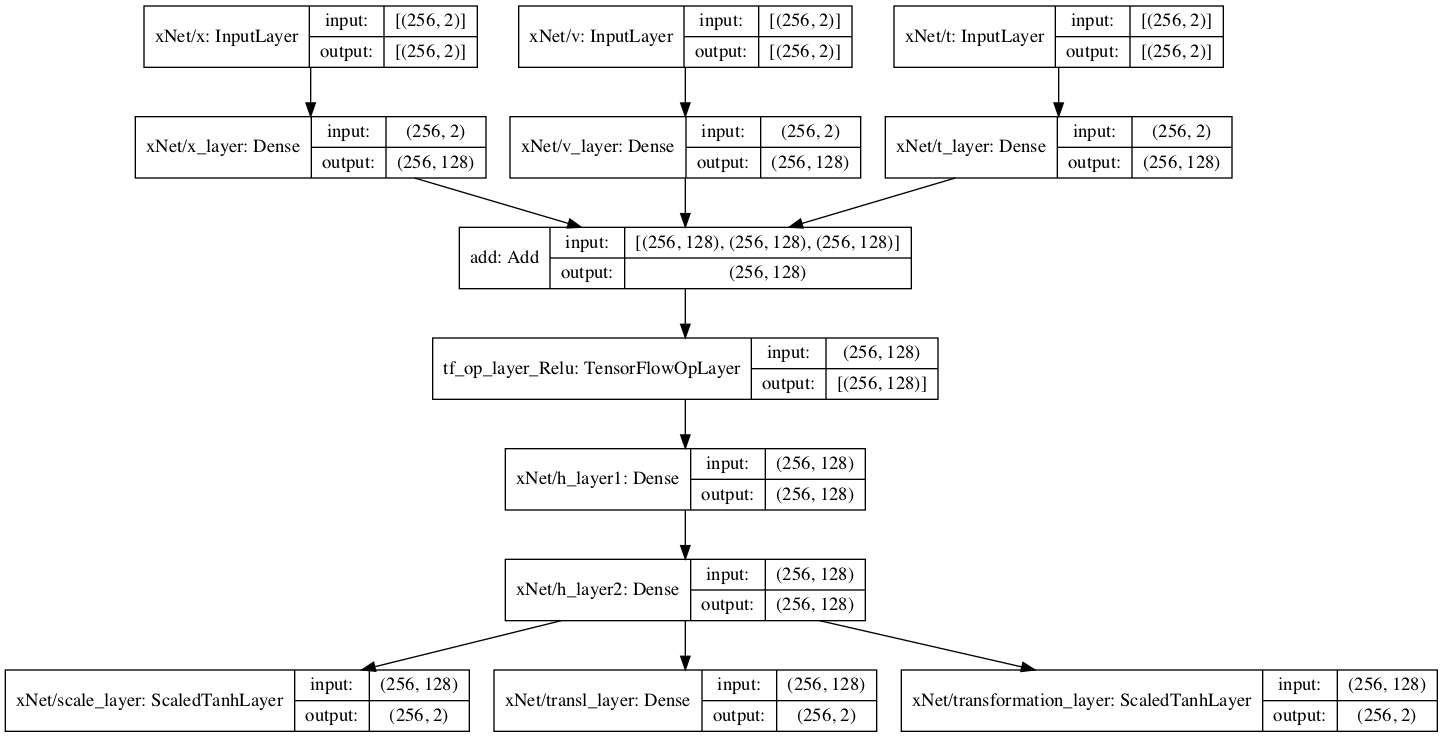

In [23]:
tf.keras.utils.plot_model(dynamics.xnet, show_shapes=True)

### Train L2HMC sampler using HMC sampler as starting point

In [24]:
flags.restore = False

In [ ]:
dirs = io.setup_directories(flags)
x = tf.random.normal(dynamics.x_shape)
x, train_data = train_dynamics(dynamics, flags, dirs=dirs, x=x)

2020-09-28 17:18:10,638:INFO:Creating directory: /Users/saforem2/l2hmc-qcd/logs/gmm/2020-09-28/2020-09-28-171311/training
2020-09-28 17:18:10,639:INFO:Creating directory: /Users/saforem2/l2hmc-qcd/logs/gmm/2020-09-28/2020-09-28-171311/training/train_data
2020-09-28 17:18:10,640:INFO:Creating directory: /Users/saforem2/l2hmc-qcd/logs/gmm/2020-09-28/2020-09-28-171311/training/checkpoints
2020-09-28 17:18:10,641:INFO:Creating directory: /Users/saforem2/l2hmc-qcd/logs/gmm/2020-09-28/2020-09-28-171311/training/summaries
2020-09-28 17:18:10,642:INFO:Creating directory: /Users/saforem2/l2hmc-qcd/logs/gmm/2020-09-28/2020-09-28-171311/training/dynamics_configs
2020-09-28 17:18:10,644:INFO:Saving FLAGS to /Users/saforem2/l2hmc-qcd/logs/gmm/2020-09-28/2020-09-28-171311/training/FLAGS.z.
2020-09-28 17:18:12,092:INFO:************************************************************************************************************************
2020-09-28 17:18:30,847:INFO:Compiled `dynamics.train_step` usi

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
     0/5000     0.05554      31.02       0.9962     0.01002       0.01     0.0002881  
     1/5000     0.05347      21.39       0.9963     0.01003     0.01001    -0.0006149 
     2/5000      0.0516      29.27       0.9971     0.01005     0.01002     9.84e-05  
     3/5000     0.05271      19.12       0.9956     0.01006     0.01003    0.0009537  
     4/5000     0.05261      23.19       0.9971     0.01007     0.01004    -0.000875  
     5/5000     0.05319       18.4       0.9964     0.01009     0.01005     -0.00134  
     6/5000     0.05243      18.29       0.9969     0.01011     0.01006    -0.0005063 
     7/5000     0.05425      19.74       0.9969     0.01012     0.01006    -0.0003099 
     8/5000     0.05133      19.64       0.9961  

    90/5000     0.06977      9.068       0.9907     0.01403     0.01086    -0.0008343 
    91/5000     0.06868      13.02       0.9864     0.01409     0.01087    -0.000613  
    92/5000     0.07217      12.15       0.9847     0.01415     0.01088    -0.0003009 
    93/5000     0.07189      6.834       0.9864     0.01421     0.01089    -3.543e-05 
    94/5000     0.08355      12.24       0.9822     0.01427      0.0109     0.001275  
    95/5000     0.07406      7.961       0.986      0.01433     0.01091    0.0009688  
    96/5000      0.0856      7.218       0.9837     0.01439     0.01092    -0.0001542 
    97/5000     0.07498      9.879       0.9856     0.01445     0.01093     0.000495  
    98/5000     0.08521       14.1       0.9848     0.01452     0.01094      0.0005   
    99/5000     0.06935      8.788       0.9805     0.01458     0.01095    -0.0001738 
------------------------------------------------------------------------------------
    step         dt         loss    accept_pr

   180/5000      0.1086      5.469       0.9379     0.01953      0.0118    0.0003266  
   181/5000      0.1484      1.951       0.936      0.01959     0.01181    -0.001977  
   182/5000      0.1422      5.254       0.9345     0.01965     0.01182     0.003672  
   183/5000      0.1453      1.775       0.9501     0.01971     0.01184    -0.003935  
   184/5000       0.14       4.265       0.9342     0.01977     0.01185     0.003471  
   185/5000      0.1264      3.823       0.9328     0.01983     0.01186     -0.00212  
   186/5000      0.1505      1.892       0.9342     0.01989     0.01187    -0.0005088 
   187/5000     0.09824      1.927       0.9357     0.01995     0.01188    -0.0005406 
   188/5000      0.1764      6.172       0.9371     0.02001     0.01189    -8.94e-05  
   189/5000      0.1229      0.8067      0.9202     0.02007      0.0119    0.0001987  
   190/5000      0.1626      1.354       0.9418     0.02012     0.01191    -0.004496  
   191/5000      0.1022      1.621       0.

   271/5000      0.1037      -4.931      0.7569      0.0252     0.01283     0.001078  
   272/5000     0.08727      -4.52       0.7488     0.02527     0.01285    -0.001948  
   273/5000     0.08437      -3.655      0.7424     0.02533     0.01286     0.005027  
   274/5000     0.08251      -2.83       0.7448      0.0254     0.01287    0.0006473  
   275/5000     0.08946      -3.014      0.7383     0.02546     0.01288    -0.002224  
   276/5000     0.08748      -4.463      0.7503     0.02552     0.01289     0.002285  
   277/5000     0.08811      -4.511      0.7523     0.02558     0.01291     0.001265  
   278/5000     0.08694      -3.761      0.7357     0.02564     0.01292     -0.00646  
   279/5000     0.08378      -3.946      0.7115      0.0257     0.01293     9.69e-05  
   280/5000     0.08574      -3.398       0.71      0.02576     0.01294    -0.002864  
   281/5000     0.08829      -3.426      0.7271     0.02581     0.01295    -0.001763  
   282/5000     0.08989      -4.282      0.

   361/5000     0.09078      -10.89      0.6031     0.03202     0.01394    -0.004255  
   362/5000      0.1084      -15.1       0.5952     0.03215     0.01396     0.02478   
   363/5000      0.0948      -15.01      0.5831     0.03227     0.01397     0.01682   
   364/5000      0.1121      -12.56      0.5722     0.03239     0.01398    -0.0003544 
   365/5000     0.08823      -9.846      0.5566     0.03248     0.01399     0.01286   
   366/5000      0.1166      -11.2       0.5377     0.03256     0.01401    -0.009835  
   367/5000     0.09747      -10.09      0.5015      0.0326     0.01402     -0.03129  
   368/5000      0.1128      -17.38      0.5539     0.03265     0.01403     0.008639  
   369/5000     0.09937      -16.39      0.5695      0.0327     0.01405     -0.01443  
   370/5000      0.1089      -17.39      0.5409     0.03275     0.01406     -0.02366  
   371/5000     0.09491      -14.91      0.5606      0.0328     0.01407     0.004794  
   372/5000      0.1032      -15.79      0.

   450/5000     0.08574      -56.46      0.8056     0.03854     0.01513    0.0001119  
   451/5000      0.1188      -61.07      0.7847     0.03864     0.01515    -0.006825  
   452/5000      0.1363      -60.28      0.767      0.03875     0.01516    -0.008359  
   453/5000     0.09119      -62.42      0.7755     0.03894     0.01518    -0.001226  
   454/5000     0.09278      -63.25      0.7891     0.03915     0.01519    -0.001574  
   455/5000     0.08655      -63.83      0.8181     0.03937      0.0152     0.01044   
   456/5000      0.0849      -62.05      0.8081     0.03963     0.01522    -0.004049  
   457/5000     0.08833      -63.4       0.8061     0.03989     0.01523     0.002702  
   458/5000     0.08794      -60.77      0.8168     0.04014     0.01525     0.01304   
   459/5000     0.08747      -62.95      0.8347     0.04042     0.01526     0.004888  
   460/5000     0.08944      -71.02      0.852      0.04073     0.01527    -0.002196  
   461/5000      0.1054      -67.43      0.

   544/5000     0.08454      -77.61      0.8773     0.04261      0.0165     0.003881  
   545/5000     0.08377      -75.42      0.8826     0.04265     0.01652     0.01053   
   546/5000     0.08323      -77.52      0.8861     0.04267     0.01653    -0.002518  
   547/5000     0.08158      -78.71      0.8938     0.04268     0.01655    -0.002881  
   548/5000      0.0854      -79.59      0.8847     0.04268     0.01656     0.001494  
   549/5000     0.08488      -82.99      0.8928     0.04266     0.01658     0.006714  
------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
   550/5000     0.08139      -82.89      0.8801     0.04257     0.01659    -0.004945  
   551/5000     0.08792      -85.29      0.8939     0.04248     0.01661     0.00188   
   552/5000     0.08519      -85.21      0.8856  

   634/5000     0.08976      -86.19      0.9435     0.04186     0.01793     0.01437   
   635/5000     0.08673      -86.8       0.9299      0.0419     0.01795     -0.01146  
   636/5000     0.07959      -87.11      0.9252     0.04191     0.01796     0.00127   
   637/5000     0.07774      -88.27      0.9348     0.04187     0.01798    -0.004084  
   638/5000     0.07914      -89.5       0.9481     0.04181     0.01799    -0.003194  
   639/5000     0.07854      -86.81      0.9474     0.04178     0.01801    -0.004812  
   640/5000     0.08129      -87.91      0.9487      0.0418     0.01803     0.003107  
   641/5000     0.07956      -86.24      0.9372     0.04181     0.01804    -0.0006912 
   642/5000     0.08751      -85.16      0.9403     0.04179     0.01806    -0.001907  
   643/5000     0.07758      -86.79      0.9411     0.04175     0.01808    -0.004476  
   644/5000     0.07974      -86.37      0.9444     0.04168     0.01809     0.009964  
   645/5000     0.08597      -84.99      0.

   724/5000      0.0763      -80.43      0.9419     0.04021     0.01948    -0.006802  
   725/5000     0.07816      -80.96      0.9445     0.04014      0.0195    -0.002858  
   726/5000      0.0758      -82.4       0.9478     0.04013     0.01951     0.007126  
   727/5000     0.08852      -82.88      0.9455     0.04017     0.01953     0.002728  
   728/5000     0.08434      -84.04      0.9502     0.04026     0.01955     -0.00275  
   729/5000     0.08726      -82.56      0.9525     0.04034     0.01957     0.004233  
   730/5000     0.09195      -82.27      0.9552     0.04041     0.01959     -0.01123  
   731/5000     0.07829      -81.63      0.9505     0.04044      0.0196     0.008339  
   732/5000     0.07774      -81.78      0.9428      0.0404     0.01962     -0.01472  
   733/5000      0.0787      -80.02      0.9374     0.04036     0.01964     0.009688  
   734/5000     0.08287      -82.6       0.9496     0.04032     0.01966    -0.0004924 
   735/5000     0.08009      -82.55      0.

   814/5000     0.09459      -73.95      0.9241     0.03945     0.02116    -0.002955  
   815/5000     0.08779      -72.97      0.9232     0.03946     0.02118    -0.003185  
   816/5000     0.09373      -73.41      0.9139     0.03953      0.0212    -0.0008346 
   817/5000      0.1218      -75.04      0.9263     0.03961     0.02122     0.003383  
   818/5000     0.09575      -76.61      0.9405     0.03968     0.02124    -0.004318  
   819/5000      0.102       -76.33      0.9337     0.03977     0.02126     0.002491  
   820/5000      0.1008      -76.29      0.9406     0.03982     0.02128     -0.00442  
   821/5000     0.09994      -76.95      0.9317     0.03979      0.0213     0.005778  
   822/5000      0.1196      -77.29      0.9466     0.03973     0.02132    -0.002603  
   823/5000      0.1179      -76.9       0.9512     0.03969     0.02134     0.00163   
   824/5000      0.1017      -77.21      0.9538     0.03961     0.02136    -0.003403  
   825/5000      0.1259      -79.59      0.

   904/5000     0.08097      -76.31      0.9386     0.03855     0.02299    -0.005231  
   905/5000     0.08036      -79.49      0.9588     0.03848     0.02301     0.01163   
   906/5000     0.07481      -80.35      0.9578     0.03849     0.02303     0.003509  
   907/5000     0.07403      -77.9       0.9362     0.03858     0.02305     0.003254  
   908/5000     0.07119      -79.89      0.9586      0.0387     0.02307    -0.000877  
   909/5000     0.07245      -80.37      0.9546     0.03884      0.0231    -0.0003234 
   910/5000     0.07615      -79.66      0.9598     0.03891     0.02312     0.001307  
   911/5000     0.07712      -79.31      0.9587     0.03887     0.02314    -0.0002468 
   912/5000     0.07523      -78.71      0.9557     0.03875     0.02316    -0.003336  
   913/5000     0.07227      -78.62      0.9515     0.03859     0.02318     0.003227  
   914/5000     0.07397      -79.38      0.9573     0.03841      0.0232    -0.001574  
   915/5000     0.07415      -79.68      0.

   997/5000     0.08665      -69.28      0.8953      0.0378     0.02504     -0.01918  
   998/5000     0.08911      -72.88      0.9201     0.03783     0.02507     0.002419  
Saving configs from rank 0 to: /Users/saforem2/l2hmc-qcd/logs/gmm/2020-09-28/2020-09-28-171311/training/train_data/x_rank0.z.
   999/5000     0.08339      -73.21      0.9187     0.03789     0.02509    -0.006467  
------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  1000/5000     0.09125      -72.58      0.9202     0.03791     0.02511    0.0006792  
  1001/5000     0.09101      -73.2       0.9363     0.03791     0.02514    -0.006382  
  1002/5000     0.08337      -74.81      0.9383     0.03789     0.02516    -0.002088  
  1003/5000     0.07616      -75.24      0.9402     0.03786     0.02518     -0.00279  
  1004/500

  1086/5000     0.07698      -74.91      0.9536     0.03641     0.02718    -0.001312  
  1087/5000     0.08144      -74.17      0.9533      0.0364     0.02721     0.003026  
  1088/5000     0.07561      -73.89      0.9553      0.0364     0.02723    -0.003357  
  1089/5000     0.07363      -73.54      0.9526     0.03639     0.02726    0.0003428  
  1090/5000     0.09265      -72.37      0.9457     0.03644     0.02728    -0.000997  
  1091/5000     0.08832      -73.29      0.9485     0.03649     0.02731    -0.001288  
  1092/5000     0.08266      -72.6       0.948      0.03657     0.02733     0.003936  
  1093/5000     0.08361      -72.09      0.9388     0.03656     0.02736    -0.003687  
  1094/5000     0.09719      -74.15      0.9506     0.03649     0.02738    -0.004063  
  1095/5000     0.08379      -73.65      0.9577     0.03654     0.02741     -0.00444  
  1096/5000      0.0882      -73.78      0.963      0.03658     0.02744    -0.002208  
  1097/5000     0.08986      -71.86      0.

  1177/5000     0.08099      -68.49      0.9593     0.03588     0.02956     -0.00118  
  1178/5000      0.0782      -69.28      0.9654     0.03587     0.02959    -0.001204  
  1179/5000     0.08688      -69.95      0.9615     0.03593     0.02961     0.006503  
  1180/5000     0.07649      -70.76      0.9698     0.03589     0.02964     0.006449  
  1181/5000     0.08224      -69.96      0.9624     0.03575     0.02967     0.005922  
  1182/5000     0.07344      -71.02      0.9676     0.03564      0.0297     -0.00535  
  1183/5000     0.07494      -69.25      0.9525     0.03554     0.02972    -0.004282  
  1184/5000     0.07472      -71.84      0.9634     0.03552     0.02975     0.006271  
  1185/5000     0.08555      -71.68      0.9631     0.03562     0.02978     0.00183   
  1186/5000     0.08249      -72.54      0.9656     0.03575     0.02981    -0.002108  
  1187/5000     0.07448      -72.76      0.9686     0.03584     0.02983     0.000287  
  1188/5000     0.07315      -71.89      0.

  1267/5000     0.07901      -65.98      0.9547     0.03547     0.03211     -0.00185  
  1268/5000     0.08884      -65.86      0.9648     0.03532     0.03214     0.002801  
  1269/5000     0.08729      -65.2       0.9635     0.03511     0.03217     0.001628  
  1270/5000     0.07407      -64.97      0.9603      0.035       0.0322    -0.0003977 
  1271/5000     0.08409      -64.46      0.9555     0.03497     0.03223    0.0002005  
  1272/5000     0.07934      -64.11      0.9587     0.03503     0.03226     0.001053  
  1273/5000     0.07643      -64.77       0.96      0.03519     0.03229     0.004021  
  1274/5000     0.07597      -63.74      0.9579     0.03532     0.03232    -0.007129  
  1275/5000     0.07958      -63.5       0.9585     0.03537     0.03235    0.0002588  
  1276/5000     0.08711      -63.48      0.9561     0.03537     0.03238     0.007743  
  1277/5000     0.08016      -63.15      0.9487     0.03531     0.03241    -0.0006871 
  1278/5000      0.0776      -63.98      0.

  1357/5000     0.07394      -63.02      0.9588     0.03476     0.03489     0.002518  
  1358/5000     0.08371      -63.56      0.9654     0.03468     0.03492    -0.002795  
  1359/5000     0.08356      -62.84      0.9537      0.0346     0.03495     0.001531  
  1360/5000     0.07533      -64.01      0.9643     0.03464     0.03499     0.00306   
  1361/5000     0.08496      -62.15      0.9577     0.03473     0.03502    -0.0001273 
  1362/5000     0.08094      -62.29      0.9564     0.03458     0.03505     0.001251  
  1363/5000     0.08616      -62.93      0.9563     0.03461     0.03508    -0.0009377 
  1364/5000     0.07323      -63.37      0.9588     0.03469     0.03511     0.005154  
  1365/5000      0.0749      -63.27      0.9559     0.03474     0.03515    -0.001225  
  1366/5000     0.08183      -63.82      0.9596     0.03475     0.03518     0.001789  
  1367/5000     0.07489      -63.01      0.9443     0.03469     0.03521     0.001304  
  1368/5000     0.07443      -62.95      0.

  1450/5000     0.07424      -61.2       0.9607     0.03418     0.03801     0.002073  
  1451/5000      0.0767      -60.42      0.9596     0.03414     0.03804    -0.001728  
  1452/5000     0.07614      -61.75      0.9654     0.03417     0.03808     0.001492  
  1453/5000     0.07413      -60.65      0.9612     0.03415     0.03811     -0.00102  
  1454/5000      0.0754      -61.01      0.9666     0.03417     0.03815    -0.0003208 
  1455/5000     0.07383      -61.32      0.9692     0.03421     0.03818    -9.541e-05 
  1456/5000     0.08165      -60.17      0.963      0.03424     0.03822    -0.001249  
  1457/5000     0.08269      -60.85      0.9622     0.03429     0.03825    6.997e-05  
  1458/5000     0.08006      -60.42      0.9668     0.03435     0.03829    -0.0005008 
  1459/5000     0.09499      -59.62      0.9496     0.03434     0.03832    0.0003146  
  1460/5000     0.07548      -60.34      0.9592     0.03425     0.03836     0.002479  
  1461/5000     0.07533      -61.11       0

## Run inference

In [16]:
import utils.file_io as io

#dirs = io.setup_directories(flags)

ckpt = tf.train.Checkpoint(model=dynamics, optimizer=dynamics.optimizer)
manager = tf.train.CheckpointManager(ckpt, dirs.ckpt_dir, max_to_keep=5)
if manager.latest_checkpoint:
    io.log(f'INFO:Checkpoint restored from: {manager.latest_checkpoint}')
    ckpt.restore(manager.latest_checkpoint)
    current_step = dynamics.optimizer.iterations.numpy()

2020-09-28 16:54:15,727:INFO:INFO:Checkpoint restored from: /Users/saforem2/l2hmc-qcd/logs/gmm/2020-09-28/2020-09-28-162720/training/checkpoints/ckpt-11


[autoreload of network.layers failed: Traceback (most recent call last):
  File "/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 302, in update_class
    if update_generic(old_obj, new_obj): continue
  File "/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.7/site-packages/IPython/ex

In [17]:
from utils.inference_utils import run_dynamics
import utils.file_io as io

flags.log_dir = dirs.log_dir
flags.beta = flags.beta_final

summary_dir = os.path.join(flags.log_dir, 'inference', 'summaries')
io.check_else_make_dir(summary_dir)
writer = tf.summary.create_file_writer(summary_dir)
writer.set_as_default()

flags.run_steps = 5000
run_data, x, x_arr = run_dynamics(dynamics, flags, save_x=True)

writer.flush()
writer.close()

2020-09-28 16:54:34,755:INFO:Creating directory: /Users/saforem2/l2hmc-qcd/logs/gmm/2020-09-28/2020-09-28-162720/inference/summaries
2020-09-28 16:54:34,758:INFO:Running inference with:
 beta: 1.0
eps: 0.01679
net_weights: NetWeights(x_scale=1.0, x_translation=1.0, x_transformation=1.0, v_scale=1.0, v_translation=1.0, v_transformation=1.0)
------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------


     0/5000     0.01758      -158.7      0.6247     0.01679        1       0.0002572  
     1/5000     0.01388      -161.5       0.63      0.01679        1       -0.0004477 
     2/5000     0.01386      -174.8      0.6688     0.01679        1       -0.0003975 
     3/5000     0.01464      -169.9      0.6586     0.01679        1       -0.0001844 
     4/5000      0.0138      -155.5      0.6251     0.01679        1       -0.0009418 
     5/5000     0.01446      -172.1      0.671      0.01679        1       -0.0005506 
     6/5000     0.01328      -170.5      0.6536     0.01679        1       -0.0001899 
     7/5000     0.01308      -176.4      0.6808     0.01679        1       7.829e-05  
     8/5000     0.01467      -179.1      0.6842     0.01679        1       -0.001264  
     9/5000     0.01492      -168.1      0.6518     0.01679        1       -5.934e-05 
    10/5000     0.01298       -182       0.6926     0.01679        1       -0.0003457 
    11/5000     0.01208      -167.5      0.

   100/5000     0.01714      -183.4      0.7081     0.01679        1       -0.0009736 
   101/5000     0.02124      -179.2      0.6928     0.01679        1       -0.0007173 
   102/5000     0.03262      -194.6      0.7406     0.01679        1       0.0001364  
   103/5000     0.01775      -181.2      0.7042     0.01679        1       -0.0008626 
   104/5000     0.01582      -196.2      0.7422     0.01679        1       0.0002992  
   105/5000     0.01533      -201.6      0.7556     0.01679        1       -0.001722  
   106/5000     0.01625      -192.7      0.7463     0.01679        1       -0.0004612 
   107/5000     0.01674      -193.7      0.7438     0.01679        1       -0.0006142 
   108/5000     0.01582      -192.3      0.7309     0.01679        1       -0.001015  
   109/5000     0.01692      -193.2      0.7404     0.01679        1       -0.0009432 
   110/5000     0.01385      -198.6      0.7616     0.01679        1       -0.001493  
   111/5000     0.01329      -197.6      0.

   201/5000     0.01318      -210.4      0.8067     0.01679        1       -0.0001614 
   202/5000     0.01347      -198.4      0.7749     0.01679        1        -0.00052  
   203/5000     0.01377      -194.1      0.7609     0.01679        1       -0.0002691 
   204/5000     0.01313      -194.6      0.7694     0.01679        1       9.094e-05  
   205/5000     0.01258      -203.5      0.7978     0.01679        1       9.559e-05  
   206/5000     0.01303      -200.9      0.787      0.01679        1       -0.001271  
   207/5000     0.01404      -202.1      0.7962     0.01679        1       4.741e-05  
   208/5000     0.01474      -203.7      0.7882     0.01679        1       -0.0003587 
   209/5000      0.0203      -199.5      0.7877     0.01679        1       -1.958e-05 
   210/5000     0.02046      -203.6      0.7937     0.01679        1       -0.0001365 
   211/5000     0.01775      -203.7      0.7958     0.01679        1       -0.0002298 
   212/5000     0.01709      -196.8      0.

   296/5000     0.02915      -200.9      0.8097     0.01679        1       -0.0006962 
   297/5000     0.01657      -195.3      0.7996     0.01679        1       6.126e-05  
   298/5000     0.01798      -198.9      0.8016     0.01679        1       -0.000431  
   299/5000     0.03484      -201.1      0.8142     0.01679        1       -0.0004708 
   300/5000     0.03036      -198.3      0.8081     0.01679        1       -0.0004672 
   301/5000     0.02995       -212       0.8497     0.01679        1       0.0003478  
   302/5000     0.01915      -195.9      0.798      0.01679        1       -0.0002161 
   303/5000     0.02438       -198       0.8075     0.01679        1       0.0005638  
   304/5000     0.01995      -199.5      0.8018     0.01679        1       -0.0004045 
   305/5000     0.01638      -203.5      0.8182     0.01679        1       0.0001022  
   306/5000     0.02046      -207.9      0.8294     0.01679        1       -0.0005644 
   307/5000     0.02068      -206.8      0.

   391/5000     0.01991      -203.1      0.829      0.01679        1       -0.000569  
   392/5000     0.01936      -209.7      0.8522     0.01679        1       -0.0003757 
   393/5000     0.01976      -199.8      0.8235     0.01679        1       -6.149e-05 
   394/5000     0.01904      -203.3      0.8355     0.01679        1       -0.0008961 
   395/5000     0.01853       -202       0.8292     0.01679        1       -0.0002771 
   396/5000     0.01794      -204.2      0.8387     0.01679        1       0.0008192  
   397/5000     0.01938      -210.5      0.8593     0.01679        1       -0.0002179 
   398/5000     0.02157      -206.2      0.8442     0.01679        1       -0.0008407 
   399/5000     0.01897      -207.4      0.8526     0.01679        1       0.0005767  
   400/5000     0.02065      -205.6      0.8417     0.01679        1       0.0009173  
   401/5000     0.02162      -204.2      0.8378     0.01679        1       -0.0009318 
   402/5000     0.02169      -199.1      0.

   487/5000     0.01936      -205.6      0.858      0.01679        1       -0.0001553 
   488/5000     0.01937       -206       0.856      0.01679        1       -0.0001626 
   489/5000     0.01863      -203.2      0.8461     0.01679        1       -0.000468  
   490/5000     0.01907      -203.2      0.8492     0.01679        1       -0.0008166 
   491/5000     0.01828      -202.2      0.847      0.01679        1        0.001617  
   492/5000     0.02016      -197.3      0.8318     0.01679        1       0.0006559  
   493/5000     0.02106      -207.2      0.8618     0.01679        1       -0.0001574 
   494/5000     0.02031       -205       0.8547     0.01679        1       -0.0007347 
   495/5000      0.0208      -199.7      0.8362     0.01679        1       -0.0004182 
   496/5000     0.02037      -205.2      0.8542     0.01679        1       0.0006946  
   497/5000      0.0211       -204       0.8506     0.01679        1       -3.666e-06 
   498/5000     0.01941      -203.3      0.

   586/5000     0.02087      -208.5      0.8818     0.01679        1       -0.0002862 
   587/5000     0.02071      -207.5      0.8802     0.01679        1        -0.00107  
   588/5000     0.02332      -207.9      0.8807     0.01679        1       -1.307e-05 
   589/5000     0.02222      -203.7      0.8648     0.01679        1        -0.00121  
   590/5000     0.02331      -203.9      0.8664     0.01679        1       -0.0005412 
   591/5000     0.02254       -208       0.8818     0.01679        1       5.318e-05  
   592/5000     0.02459      -205.6      0.8718     0.01679        1       -0.001108  
   593/5000     0.02834      -204.3      0.8663     0.01679        1       0.0004828  
   594/5000      0.0196      -204.9      0.8674     0.01679        1       0.0003026  
   595/5000     0.02153      -201.2      0.8538     0.01679        1       -0.0001244 
   596/5000     0.02058      -202.6      0.858      0.01679        1       -8.361e-05 
   597/5000     0.02052       -205       0.

   681/5000     0.02603      -199.1      0.865      0.01679        1       -0.0003348 
   682/5000     0.02662      -202.8      0.8785     0.01679        1       -1.182e-05 
   683/5000     0.02592      -201.7      0.8817     0.01679        1       0.0005156  
   684/5000     0.02572      -203.9      0.8909     0.01679        1       -0.001263  
   685/5000     0.02697      -199.2      0.8675     0.01679        1        0.001059  
   686/5000     0.02533      -207.6      0.8972     0.01679        1        0.000218  
   687/5000     0.02719      -208.6      0.9011     0.01679        1       0.0001559  
   688/5000     0.02807      -204.5      0.8865     0.01679        1       -0.0001659 
   689/5000     0.02314      -205.5      0.8869     0.01679        1       6.694e-05  
   690/5000     0.02422      -202.9      0.8754     0.01679        1       -0.0001648 
   691/5000     0.02512      -204.6      0.8828     0.01679        1       0.0002769  
   692/5000     0.02851      -206.4      0.

   780/5000     0.02158      -201.5      0.8906     0.01679        1       -4.791e-06 
   781/5000     0.02591      -205.3      0.9058     0.01679        1        0.000235  
   782/5000     0.02402      -202.3      0.8927     0.01679        1       0.0005532  
   783/5000     0.02083      -198.4      0.8793     0.01679        1       0.0001839  
   784/5000      0.023       -202.9      0.8959     0.01679        1       -0.0003564 
   785/5000     0.02162      -199.2      0.8838     0.01679        1       -2.165e-05 
   786/5000      0.0226      -199.8      0.8805     0.01679        1       -0.0003908 
   787/5000     0.02328      -202.9      0.8969     0.01679        1       0.0002763  
   788/5000     0.01998      -204.1      0.9025     0.01679        1       -0.0003959 
   789/5000     0.02038      -203.7      0.9006     0.01679        1       -0.0004326 
   790/5000     0.02213      -199.2      0.8842     0.01679        1       -0.0003594 
   791/5000     0.02181      -200.8      0.

   877/5000     0.02599      -202.4      0.9044     0.01679        1       0.0004533  
   878/5000     0.02584       -201       0.9033     0.01679        1       0.0002683  
   879/5000     0.02648      -197.6      0.8877     0.01679        1       0.0009088  
   880/5000      0.0248      -196.9      0.8844     0.01679        1        0.001075  
   881/5000     0.02281      -202.8      0.9079     0.01679        1       -0.0002216 
   882/5000     0.02422      -204.9      0.9147     0.01679        1       0.0005074  
   883/5000     0.02437      -200.6      0.8994     0.01679        1       -0.0002679 
   884/5000     0.02469      -199.9      0.8979     0.01679        1       0.0003293  
   885/5000     0.02191      -201.9      0.9107     0.01679        1       0.0001749  
   886/5000     0.02317      -195.8      0.8823     0.01679        1       -0.0005887 
   887/5000     0.02084      -196.9      0.8908     0.01679        1       3.972e-05  
   888/5000     0.02396      -198.3      0.

   972/5000     0.02144      -193.1      0.8883     0.01679        1       -0.0001259 
   973/5000     0.02374      -194.5      0.896      0.01679        1       0.0005251  
   974/5000     0.02227      -194.9      0.8981     0.01679        1       -0.0001458 
   975/5000     0.02072      -195.9      0.9009     0.01679        1       -0.0005888 
   976/5000     0.02367       -200       0.913      0.01679        1       -0.0002622 
   977/5000     0.02125      -193.9      0.8904     0.01679        1       0.0003303  
   978/5000     0.02309      -194.9      0.8978     0.01679        1       -0.0007685 
   979/5000     0.02465      -197.8      0.9074     0.01679        1       4.705e-05  
   980/5000     0.02122      -197.3      0.9056     0.01679        1       -6.434e-05 
   981/5000     0.02073      -198.5      0.9092     0.01679        1       -0.0003837 
   982/5000     0.02567       -195       0.8951     0.01679        1       -0.0006682 
   983/5000     0.02404      -195.7      0.

  1065/5000     0.02479      -194.7      0.8949     0.01679        1       0.0003262  
  1066/5000     0.02727      -197.7       0.91      0.01679        1       -4.91e-05  
  1067/5000     0.02636      -198.5      0.9101     0.01679        1        9.4e-05   
  1068/5000     0.03481      -198.9      0.9136     0.01679        1       -0.001621  
  1069/5000     0.02613      -199.7      0.9148     0.01679        1       0.0003923  
  1070/5000      0.0304      -199.7      0.9167     0.01679        1       -0.0005999 
  1071/5000     0.02832      -193.6      0.8945     0.01679        1       -0.0001491 
  1072/5000     0.02677      -194.8      0.8918     0.01679        1       0.0009978  
  1073/5000     0.02814      -195.3      0.8938     0.01679        1       -0.0001669 
  1074/5000     0.02527      -198.2      0.9074     0.01679        1       -0.0007463 
  1075/5000      0.023       -198.2      0.9052     0.01679        1       -1.211e-05 
  1076/5000     0.02576      -194.3      0.

  1162/5000     0.02628      -195.4      0.9096     0.01679        1       -0.0006318 
  1163/5000     0.02736      -195.6      0.9101     0.01679        1       0.0008245  
  1164/5000     0.02568      -195.1      0.9084     0.01679        1       0.0002142  
  1165/5000     0.02377      -198.2      0.9233     0.01679        1       -0.0006767 
  1166/5000     0.02468       -194       0.9058     0.01679        1       3.738e-05  
  1167/5000     0.02418      -194.6      0.9081     0.01679        1       -0.0001598 
  1168/5000     0.02459       -194       0.9029     0.01679        1       0.0006859  
  1169/5000     0.02578      -196.6      0.9148     0.01679        1       0.0002347  
  1170/5000     0.02589      -196.2      0.9118     0.01679        1       -0.0002026 
  1171/5000     0.02457      -198.3      0.9178     0.01679        1       -0.0002947 
  1172/5000      0.0251      -197.4      0.9164     0.01679        1       -0.0002682 
  1173/5000     0.02516      -197.2      0.

  1260/5000     0.02886      -196.7      0.9134     0.01679        1       0.0001623  
  1261/5000     0.02663      -195.7      0.9117     0.01679        1       -0.0001837 
  1262/5000      0.0279       -197       0.9173     0.01679        1       -0.0002953 
  1263/5000     0.02935      -195.8      0.9156     0.01679        1       -0.0008237 
  1264/5000     0.02597      -195.4      0.9136     0.01679        1       0.0001286  
  1265/5000     0.02913      -194.6      0.9092     0.01679        1       0.0003024  
  1266/5000     0.02552       -198       0.9233     0.01679        1       0.0006821  
  1267/5000     0.02725      -197.7      0.9238     0.01679        1       -8.674e-05 
  1268/5000     0.03364      -194.3       0.91      0.01679        1       0.0008016  
  1269/5000     0.02961      -197.2      0.919      0.01679        1       3.164e-05  
  1270/5000     0.02606      -191.2      0.8968     0.01679        1        0.001022  
  1271/5000     0.02723      -192.5      0.

  1357/5000     0.02329      -199.8      0.9315     0.01679        1        0.000612  
  1358/5000     0.02609      -196.9      0.9209     0.01679        1       -0.001121  
  1359/5000     0.02524       -195       0.9142     0.01679        1        0.001199  
  1360/5000     0.02434      -196.4      0.9194     0.01679        1       -0.0003449 
  1361/5000     0.02477      -190.8      0.8998     0.01679        1       0.0004976  
  1362/5000     0.02413      -194.2      0.9099     0.01679        1       1.166e-05  
  1363/5000     0.02491      -194.1      0.9136     0.01679        1       -0.0005942 
  1364/5000     0.02479      -196.6      0.924      0.01679        1       -0.0007536 
  1365/5000     0.02585      -195.3      0.9217     0.01679        1       -0.001392  
  1366/5000     0.02469      -195.8      0.9179     0.01679        1       -0.0001131 
  1367/5000     0.02557      -194.5      0.914      0.01679        1       -0.0005371 
  1368/5000      0.0254      -197.7      0.

  1452/5000     0.02555      -193.1      0.9207     0.01679        1       0.0003566  
  1453/5000     0.02689      -194.7      0.9291     0.01679        1       -0.0008988 
  1454/5000     0.02729      -194.5      0.9266     0.01679        1       -0.0005373 
  1455/5000     0.02328      -194.7      0.926      0.01679        1       -0.0003739 
  1456/5000      0.0222      -194.4      0.9256     0.01679        1       0.0007907  
  1457/5000     0.02526      -194.1      0.9251     0.01679        1       0.0002141  
  1458/5000     0.02665      -194.3      0.9245     0.01679        1       0.0006321  
  1459/5000     0.02508      -195.4      0.9314     0.01679        1       -0.0003216 
  1460/5000     0.02751      -193.3      0.9208     0.01679        1       0.0007298  
  1461/5000     0.02639      -197.1      0.9411     0.01679        1       -0.0004781 
  1462/5000     0.02485      -193.5      0.9219     0.01679        1       0.0005455  
  1463/5000     0.02763      -194.6      0.

  1551/5000     0.02851      -193.1      0.9216     0.01679        1       -0.001386  
  1552/5000     0.02671      -191.3      0.9171     0.01679        1       0.0003792  
  1553/5000     0.03235      -191.4      0.9153     0.01679        1       -0.0002339 
  1554/5000     0.02625      -190.4      0.915      0.01679        1       0.0002539  
  1555/5000      0.0254      -192.1      0.9187     0.01679        1       -7.761e-05 
  1556/5000      0.0301      -191.2      0.9183     0.01679        1       0.0004309  
  1557/5000     0.02784      -193.8      0.9273     0.01679        1       -0.0004492 
  1558/5000     0.02799      -189.7      0.9138     0.01679        1       4.006e-05  
  1559/5000     0.03032      -189.5      0.9118     0.01679        1       -5.608e-05 
  1560/5000     0.02868      -191.3      0.9185     0.01679        1       0.0009181  
  1561/5000     0.03115      -191.6      0.9204     0.01679        1       -0.0002283 
  1562/5000     0.02961      -193.1      0.

  1646/5000     0.02852      -192.7      0.929      0.01679        1       -0.001325  
  1647/5000     0.02793      -191.1      0.9222     0.01679        1       -0.0007112 
  1648/5000     0.02966       -191       0.921      0.01679        1       0.0006013  
  1649/5000     0.02973       -191       0.9204     0.01679        1       -0.0003265 
  1650/5000     0.02661      -193.9      0.9337     0.01679        1        -0.00155  
  1651/5000      0.0261      -188.2      0.9089     0.01679        1       -4.192e-05 
  1652/5000     0.03002      -193.1      0.9309     0.01679        1       -0.001027  
  1653/5000     0.02883      -192.2      0.9271     0.01679        1       6.083e-05  
  1654/5000     0.02836      -192.5      0.9285     0.01679        1       -0.001475  
  1655/5000     0.03031      -191.1      0.9238     0.01679        1       -0.0003806 
  1656/5000     0.02839      -191.3      0.9233     0.01679        1       0.0007015  
  1657/5000     0.03415      -191.8      0.

  1743/5000      0.0238      -189.4      0.9239     0.01679        1       -8.925e-05 
  1744/5000     0.03069      -191.3      0.9303     0.01679        1       -0.0004328 
  1745/5000      0.0315      -191.6      0.936      0.01679        1       -0.001125  
  1746/5000      0.0288      -190.5      0.9276     0.01679        1       0.0003812  
  1747/5000     0.03186      -191.8      0.9343     0.01679        1       -0.0009577 
  1748/5000     0.03112      -190.4      0.9283     0.01679        1       0.0003578  
  1749/5000     0.03067      -191.7      0.9335     0.01679        1       0.0002242  
  1750/5000     0.02947      -188.6      0.9218     0.01679        1       -0.0005178 
  1751/5000     0.02887      -188.9      0.9239     0.01679        1       0.0004373  
  1752/5000     0.03313      -187.7      0.9165     0.01679        1       -6.256e-05 
  1753/5000     0.02945       -189       0.9237     0.01679        1        0.001594  
  1754/5000     0.02741      -189.9      0.

  1838/5000     0.03267      -188.1      0.9253     0.01679        1       -0.000403  
  1839/5000     0.03247      -191.3      0.9367     0.01679        1       -0.0008606 
  1840/5000     0.03079      -189.9      0.9317     0.01679        1       -0.0001332 
  1841/5000     0.02959      -188.4      0.9231     0.01679        1       0.0002469  
  1842/5000     0.02895      -190.2      0.9338     0.01679        1       -0.001574  
  1843/5000     0.03365      -188.5      0.9256     0.01679        1       9.136e-05  
  1844/5000     0.03437      -189.6      0.9301     0.01679        1       -8.723e-05 
  1845/5000     0.02837      -190.4      0.9363     0.01679        1       -0.001009  
  1846/5000     0.03294      -188.9      0.9288     0.01679        1       -0.0001365 
  1847/5000     0.03237      -189.4      0.9284     0.01679        1       -0.0007918 
  1848/5000     0.03582       -189       0.9255     0.01679        1       -5.307e-05 
  1849/5000      0.0296      -189.4      0.

  1935/5000     0.03018      -185.6      0.9173     0.01679        1       0.0008031  
  1936/5000     0.03156      -189.2      0.9356     0.01679        1       -0.0006421 
  1937/5000     0.03255      -187.4      0.9282     0.01679        1       -0.0004105 
  1938/5000     0.02788      -187.2      0.9256     0.01679        1       0.0008035  
  1939/5000     0.02809      -188.2      0.9293     0.01679        1        0.000359  
  1940/5000      0.0334      -187.9      0.9304     0.01679        1       -0.0007863 
  1941/5000     0.02991      -187.7      0.9239     0.01679        1       0.0009698  
  1942/5000     0.03143      -187.5      0.9258     0.01679        1       -3.069e-05 
  1943/5000      0.0295      -187.9      0.9295     0.01679        1       -0.0001693 
  1944/5000     0.03034      -188.9      0.9315     0.01679        1       -0.0009776 
  1945/5000      0.0277      -189.1      0.9349     0.01679        1       -0.0002186 
  1946/5000     0.02687      -185.9      0.

  2031/5000     0.02693      -189.6      0.9455     0.01679        1       -0.001236  
  2032/5000     0.02613      -187.9      0.9356     0.01679        1       -0.0003199 
  2033/5000     0.03233      -187.2      0.938      0.01679        1       -0.0005905 
  2034/5000     0.02784      -187.5      0.9347     0.01679        1       0.0001474  
  2035/5000     0.02792      -186.7      0.9318     0.01679        1       0.0004372  
  2036/5000     0.02973      -187.7      0.9362     0.01679        1       5.159e-05  
  2037/5000     0.02778      -186.4      0.9313     0.01679        1       0.0009997  
  2038/5000     0.02774      -188.4      0.9396     0.01679        1       -0.0005333 
  2039/5000     0.02747      -186.8      0.9327     0.01679        1       -0.0009405 
  2040/5000     0.02779      -186.1      0.9316     0.01679        1       -0.0007689 
  2041/5000     0.02666      -185.8      0.9268     0.01679        1        0.001208  
  2042/5000     0.02793      -186.3      0.

  2129/5000     0.02868      -186.8      0.9426     0.01679        1       -0.0004751 
  2130/5000     0.02926      -182.8      0.9255     0.01679        1       0.0007584  
  2131/5000     0.02853      -186.7      0.9426     0.01679        1       -0.0002927 
  2132/5000     0.02894      -183.8      0.9272     0.01679        1       -0.0003269 
  2133/5000     0.02796      -186.9      0.9436     0.01679        1       -0.0008776 
  2134/5000     0.02819      -184.8      0.9338     0.01679        1        0.000122  
  2135/5000     0.03165       -185       0.9355     0.01679        1       -0.0008501 
  2136/5000     0.03094      -184.6      0.9322     0.01679        1        0.000111  
  2137/5000     0.03169      -185.6      0.9369     0.01679        1       0.0002956  
  2138/5000     0.03119      -183.7      0.9314     0.01679        1       -0.0004217 
  2139/5000     0.03265      -186.8      0.9384     0.01679        1       0.0003469  
  2140/5000     0.02893      -184.4      0.

  2225/5000     0.03068      -184.3      0.9404     0.01679        1       -0.0004862 
  2226/5000     0.03179      -183.5      0.9378     0.01679        1       -0.000592  
  2227/5000      0.0291      -181.2      0.9264     0.01679        1       0.0007391  
  2228/5000      0.028       -181.9       0.93      0.01679        1       -0.0004864 
  2229/5000     0.03008      -183.1      0.9368     0.01679        1       0.0002059  
  2230/5000     0.02881       -183       0.9349     0.01679        1       -0.0003205 
  2231/5000     0.02926      -182.7      0.936      0.01679        1       -0.0003564 
  2232/5000     0.02832      -184.5      0.9437     0.01679        1       -0.0003355 
  2233/5000     0.02884      -183.6      0.9378     0.01679        1       0.0002578  
  2234/5000      0.027       -183.6      0.9377     0.01679        1       -0.0004202 
  2235/5000     0.02932      -183.5       0.94      0.01679        1       -0.0007819 
  2236/5000     0.03031       -184       0.

  2321/5000     0.03683       -183       0.9405     0.01679        1       0.0006985  
  2322/5000      0.0325      -182.6      0.9372     0.01679        1       0.0006294  
  2323/5000     0.03406      -182.4      0.9382     0.01679        1       0.0008759  
  2324/5000     0.02955      -183.2      0.944      0.01679        1       -0.0001267 
  2325/5000     0.03005      -181.7      0.9382     0.01679        1       -0.0002704 
  2326/5000     0.03104      -182.5      0.9374     0.01679        1       0.0009436  
  2327/5000     0.02888      -181.5      0.9356     0.01679        1       0.0007383  
  2328/5000     0.03152       -181       0.9343     0.01679        1       0.0001742  
  2329/5000     0.02942      -180.1      0.9301     0.01679        1       0.0001671  
  2330/5000     0.03751      -182.3      0.941      0.01679        1       -0.0005186 
  2331/5000      0.0313      -182.2      0.9389     0.01679        1       5.578e-05  
  2332/5000     0.02986      -183.5      0.

  2417/5000     0.02798      -181.5      0.942      0.01679        1       -0.0005349 
  2418/5000     0.02694      -181.5      0.9397     0.01679        1       -0.0005623 
  2419/5000     0.02784      -180.9      0.938      0.01679        1        0.000148  
  2420/5000     0.02771      -182.7      0.947      0.01679        1       0.0003886  
  2421/5000     0.02784      -182.4      0.9485     0.01679        1       -0.0005514 
  2422/5000      0.0273      -180.6      0.9371     0.01679        1       0.0001072  
  2423/5000     0.02955      -180.4      0.937      0.01679        1       -0.0002266 
  2424/5000     0.02696      -180.6      0.9386     0.01679        1       -0.0008205 
  2425/5000     0.02712      -181.7      0.9424     0.01679        1       -0.0007728 
  2426/5000     0.02893      -180.2      0.9348     0.01679        1       -4.455e-05 
  2427/5000     0.02782       -181       0.9364     0.01679        1       2.173e-05  
  2428/5000     0.02753      -180.9      0.

  2513/5000     0.02918      -179.6      0.9414     0.01679        1       0.0008887  
  2514/5000     0.02851      -181.6      0.9503     0.01679        1       -9.15e-05  
  2515/5000     0.02819       -180       0.9443     0.01679        1       -0.0005518 
  2516/5000     0.02976      -180.5      0.9449     0.01679        1       -0.0005225 
  2517/5000     0.03087      -178.9      0.938      0.01679        1       -0.0005012 
  2518/5000      0.0304      -180.3      0.9425     0.01679        1       -0.0001852 
  2519/5000     0.03495       -179       0.9376     0.01679        1       -0.0003297 
  2520/5000      0.0352      -179.2      0.9384     0.01679        1       0.0006058  
  2521/5000     0.03246      -178.8      0.9369     0.01679        1       0.0002422  
  2522/5000     0.03113      -179.6      0.9424     0.01679        1       -0.001281  
  2523/5000     0.03458      -180.3      0.9444     0.01679        1       -0.000424  
  2524/5000     0.03264       -182       0.

  2609/5000     0.03035      -180.2      0.939      0.01679        1       -0.0002919 
  2610/5000     0.02937      -179.6      0.9371     0.01679        1       -0.0002401 
  2611/5000     0.03151      -180.1      0.9363     0.01679        1       -0.0004377 
  2612/5000     0.03126      -180.4      0.938      0.01679        1       9.376e-05  
  2613/5000     0.03008      -181.3      0.9399     0.01679        1        0.001216  
  2614/5000      0.0322      -180.7       0.94      0.01679        1       0.0002276  
  2615/5000     0.03061      -180.8      0.9405     0.01679        1       0.0007835  
  2616/5000     0.03242      -178.5      0.929      0.01679        1       -0.000887  
  2617/5000      0.0297      -181.5      0.9452     0.01679        1       -4.804e-05 
  2618/5000     0.03002      -180.1      0.9364     0.01679        1       -0.0006086 
  2619/5000     0.03652       -181       0.9429     0.01679        1        0.000304  
  2620/5000     0.03495      -179.9      0.

  2705/5000     0.02998      -177.3      0.9374     0.01679        1       -0.0006635 
  2706/5000     0.02943      -179.3      0.9468     0.01679        1       -0.001472  
  2707/5000      0.0267      -177.8      0.9391     0.01679        1       -9.906e-05 
  2708/5000     0.02542      -181.4      0.9544     0.01679        1       -0.0003607 
  2709/5000     0.02722      -177.6      0.9384     0.01679        1       -0.0005063 
  2710/5000     0.02853      -180.2      0.9495     0.01679        1       -0.0001603 
  2711/5000     0.02807      -179.1      0.9452     0.01679        1        0.000303  
  2712/5000     0.02821      -179.2      0.9459     0.01679        1       -4.168e-05 
  2713/5000     0.02823      -177.1      0.9361     0.01679        1       0.0002644  
  2714/5000     0.02819      -178.3      0.9385     0.01679        1       0.0006097  
  2715/5000     0.02831      -178.2      0.9404     0.01679        1       0.0007829  
  2716/5000     0.02929      -178.5      0.

  2802/5000     0.02779      -177.5      0.9492     0.01679        1        0.000597  
  2803/5000      0.0271      -177.4      0.9452     0.01679        1       -0.0007269 
  2804/5000     0.02689      -175.9      0.939      0.01679        1       8.114e-06  
  2805/5000     0.02687      -176.8      0.9424     0.01679        1       -0.0009957 
  2806/5000     0.02815      -178.2      0.9501     0.01679        1       0.0002234  
  2807/5000     0.02887      -177.5      0.9464     0.01679        1       -1.957e-05 
  2808/5000     0.03138      -175.3      0.9381     0.01679        1       -0.0002953 
  2809/5000     0.03085      -178.4      0.9493     0.01679        1       -0.001069  
  2810/5000     0.02793      -175.4      0.9376     0.01679        1       0.0006595  
  2811/5000     0.02788      -179.2      0.9535     0.01679        1       -0.0008355 
  2812/5000     0.02695      -175.3      0.9356     0.01679        1       -0.0001823 
  2813/5000     0.02942       -177       0.

  2899/5000     0.02845      -176.5      0.9463     0.01679        1       -0.000636  
  2900/5000     0.02984      -174.6      0.9363     0.01679        1        0.001067  
  2901/5000     0.02998      -178.5      0.9563     0.01679        1       0.0008994  
  2902/5000     0.02831      -175.7      0.9438     0.01679        1       -0.0001282 
  2903/5000     0.02886      -176.3      0.9465     0.01679        1       0.0005197  
  2904/5000     0.02839      -175.2      0.9437     0.01679        1       8.243e-05  
  2905/5000     0.02911      -175.4      0.9435     0.01679        1        0.000855  
  2906/5000     0.02876      -175.1      0.9421     0.01679        1        0.001113  
  2907/5000     0.02919      -176.2      0.9454     0.01679        1       -0.0006403 
  2908/5000     0.02894      -176.5      0.9477     0.01679        1        0.000349  
  2909/5000     0.02936      -178.1      0.9549     0.01679        1       -0.0006963 
  2910/5000     0.02899      -175.6      0.

  2994/5000     0.02575      -171.9      0.9415     0.01679        1        0.000439  
  2995/5000     0.02506      -172.3      0.946      0.01679        1       -0.001105  
  2996/5000     0.02639      -172.5      0.9448     0.01679        1       -3.37e-05  
  2997/5000     0.02685      -173.1      0.9456     0.01679        1       0.0007621  
  2998/5000     0.02517      -173.8      0.9487     0.01679        1       -0.0004768 
  2999/5000     0.02652      -173.8      0.949      0.01679        1       -0.0002309 
------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  3000/5000     0.02547      -173.2      0.9448     0.01679        1       0.0006046  
  3001/5000     0.02863      -173.4      0.9509     0.01679        1       0.0001449  
  3002/5000     0.02924      -173.7      0.9483  

  3089/5000     0.03098      -171.2      0.9467     0.01679        1       0.0002176  
  3090/5000      0.0331      -171.2      0.9463     0.01679        1       -0.001241  
  3091/5000      0.0305      -170.5      0.942      0.01679        1        0.001149  
  3092/5000     0.02888      -171.7      0.9475     0.01679        1       -0.0007832 
  3093/5000     0.02748      -170.6      0.9439     0.01679        1       -0.001268  
  3094/5000     0.02638      -170.6      0.9425     0.01679        1       7.839e-05  
  3095/5000     0.02769      -172.1      0.951      0.01679        1       0.0003807  
  3096/5000     0.02782      -170.2      0.9414     0.01679        1       -0.0001574 
  3097/5000     0.02783      -170.7      0.9456     0.01679        1       0.0003317  
  3098/5000     0.02905      -170.1      0.9431     0.01679        1       0.0001783  
  3099/5000     0.02733      -168.6      0.9363     0.01679        1       0.0007981  
  3100/5000      0.0314      -169.1      0.

  3186/5000     0.02811      -169.9      0.9433     0.01679        1       -0.0002032 
  3187/5000     0.03185      -170.5      0.9463     0.01679        1       0.0006442  
  3188/5000     0.02922       -171       0.9522     0.01679        1       -1.278e-05 
  3189/5000     0.02912      -170.3      0.9483     0.01679        1       -5.35e-05  
  3190/5000     0.03137      -171.4      0.954      0.01679        1       -0.0007133 
  3191/5000     0.03004      -169.8      0.9462     0.01679        1       -0.0004807 
  3192/5000     0.03005       -171       0.9506     0.01679        1       3.314e-05  
  3193/5000     0.02746      -170.3      0.9484     0.01679        1       -0.0004828 
  3194/5000     0.03051      -169.9      0.9456     0.01679        1        -0.00143  
  3195/5000     0.02859      -170.4      0.9454     0.01679        1       0.0007552  
  3196/5000     0.02939       -171       0.948      0.01679        1       0.0002325  
  3197/5000     0.02667      -171.2      0.

  3282/5000     0.03263      -172.7      0.9535     0.01679        1       0.0001655  
  3283/5000      0.0335      -170.6      0.9441     0.01679        1       0.0003254  
  3284/5000     0.03525      -173.3      0.9567     0.01679        1       -0.001618  
  3285/5000     0.03433      -170.8      0.9432     0.01679        1       0.0001258  
  3286/5000     0.03675      -172.4      0.9511     0.01679        1       -0.0002685 
  3287/5000     0.03667      -170.6      0.9428     0.01679        1        0.001184  
  3288/5000     0.03372      -171.2      0.9448     0.01679        1       0.0002541  
  3289/5000     0.03239      -170.8      0.9453     0.01679        1       -0.0008048 
  3290/5000      0.0378      -171.2      0.9463     0.01679        1       -0.0002543 
  3291/5000     0.02612      -170.2      0.9418     0.01679        1       0.0004434  
  3292/5000     0.02818      -171.5      0.9477     0.01679        1       0.0002582  
  3293/5000     0.02751      -172.6      0.

  3377/5000     0.02941      -171.3      0.9533     0.01679        1       -0.0004292 
  3378/5000     0.02942      -170.5      0.9494     0.01679        1       0.0001391  
  3379/5000     0.03141      -170.4      0.9475     0.01679        1       -0.0004314 
  3380/5000     0.02982      -171.4      0.951      0.01679        1       0.0007451  
  3381/5000     0.02921       -171       0.949      0.01679        1       -2.572e-05 
  3382/5000     0.03174      -169.1      0.9428     0.01679        1       -1.808e-05 
  3383/5000      0.0318      -170.8      0.9508     0.01679        1       -0.0006103 
  3384/5000     0.03314      -172.2      0.9592     0.01679        1       -0.0004473 
  3385/5000      0.0297      -170.4      0.9465     0.01679        1       0.0001269  
  3386/5000     0.03056      -170.9      0.9482     0.01679        1       0.0001563  
  3387/5000     0.03015      -170.5      0.9475     0.01679        1        -0.00035  
  3388/5000     0.03433      -172.2      0.

  3473/5000     0.02928      -167.8      0.9417     0.01679        1        0.001373  
  3474/5000     0.03153      -168.3      0.9452     0.01679        1       0.0003052  
  3475/5000     0.03046      -167.1      0.941      0.01679        1       -0.0003178 
  3476/5000     0.04047      -167.9      0.942      0.01679        1       -0.0001073 
  3477/5000     0.03847      -169.9      0.9563     0.01679        1       -0.0002404 
  3478/5000     0.03436       -168       0.9454     0.01679        1       0.0006303  
  3479/5000     0.04156      -168.3      0.9486     0.01679        1        0.00015   
  3480/5000     0.03488      -168.8      0.9498     0.01679        1       -9.849e-05 
  3481/5000     0.03582      -167.9      0.9472     0.01679        1       -0.0001211 
  3482/5000     0.03326      -167.3      0.9454     0.01679        1        0.001068  
  3483/5000     0.03585      -167.1      0.943      0.01679        1       3.872e-05  
  3484/5000     0.03352      -167.3      0.

  3571/5000     0.03035      -166.1      0.9479     0.01679        1       -0.0008162 
  3572/5000     0.03397      -166.1      0.946      0.01679        1       0.0004525  
  3573/5000     0.03059      -166.4      0.9498     0.01679        1       9.006e-05  
  3574/5000     0.03273      -166.2      0.9475     0.01679        1       -0.0005496 
  3575/5000     0.02961      -165.8      0.9462     0.01679        1       0.0008083  
  3576/5000     0.03644      -165.7      0.9457     0.01679        1        0.001576  
  3577/5000      0.0317       -166       0.9478     0.01679        1        0.001107  
  3578/5000      0.0432      -166.4      0.9535     0.01679        1       9.466e-05  
  3579/5000     0.03428      -166.3      0.9491     0.01679        1       -0.0004301 
  3580/5000     0.03767      -165.8      0.948      0.01679        1       -0.000604  
  3581/5000     0.03296      -164.2      0.9394     0.01679        1       0.0007654  
  3582/5000     0.03519      -166.2      0.

  3669/5000      0.0274       -165       0.944      0.01679        1        0.001187  
  3670/5000     0.03037       -166       0.9484     0.01679        1       0.0008705  
  3671/5000     0.02994      -166.5      0.9501     0.01679        1       -0.0004451 
  3672/5000     0.03633      -165.2      0.9436     0.01679        1       0.0002684  
  3673/5000     0.03001      -166.4      0.9503     0.01679        1        0.001019  
  3674/5000     0.03195      -166.3      0.9519     0.01679        1       0.0002015  
  3675/5000     0.03192      -165.5      0.9452     0.01679        1       0.0009248  
  3676/5000     0.03078      -165.9      0.9492     0.01679        1       -0.0002935 
  3677/5000     0.02978      -165.8      0.949      0.01679        1       9.327e-05  
  3678/5000     0.03013      -166.3      0.9506     0.01679        1       -0.0001814 
  3679/5000     0.02979      -165.6      0.9448     0.01679        1       0.0006799  
  3680/5000     0.03102      -166.8      0.

  3765/5000     0.03149      -166.4      0.9466     0.01679        1       -0.0003776 
  3766/5000     0.03281       -168       0.9539     0.01679        1       -0.0008953 
  3767/5000     0.03568      -165.9      0.9431     0.01679        1       -0.001536  
  3768/5000     0.03266      -167.6       0.95      0.01679        1        0.001137  
  3769/5000     0.02898       -167       0.9484     0.01679        1       -0.0002934 
  3770/5000      0.0317      -167.8      0.951      0.01679        1       -0.0002953 
  3771/5000     0.02935       -166       0.9432     0.01679        1       0.0001545  
  3772/5000      0.0292      -167.6      0.9499     0.01679        1       9.137e-05  
  3773/5000     0.02709      -167.3      0.951      0.01679        1       -0.0004755 
  3774/5000     0.02987      -167.1      0.9498     0.01679        1       0.0001464  
  3775/5000     0.03265      -166.1      0.9446     0.01679        1       0.0003728  
  3776/5000     0.03061      -167.8      0.

  3862/5000     0.02919       -164       0.941      0.01679        1       0.0003798  
  3863/5000     0.03376       -167       0.957      0.01679        1       -0.0007836 
  3864/5000     0.03003      -164.7      0.9462     0.01679        1       -0.0001928 
  3865/5000     0.03007      -166.8      0.9561     0.01679        1       -0.0001779 
  3866/5000     0.02911      -166.1      0.9532     0.01679        1       -0.0008005 
  3867/5000     0.02952      -166.9      0.9557     0.01679        1       -0.0003835 
  3868/5000     0.02748      -166.1      0.954      0.01679        1       -0.0006442 
  3869/5000     0.02934       -167       0.957      0.01679        1       -0.0005268 
  3870/5000     0.03021      -165.5      0.9484     0.01679        1       -0.0006744 
  3871/5000     0.02957      -164.4      0.9413     0.01679        1       0.0002156  
  3872/5000      0.0288      -165.4      0.9465     0.01679        1       -0.000286  
  3873/5000     0.02836      -166.1      0.

  3958/5000     0.02693      -164.3      0.9492     0.01679        1        0.000774  
  3959/5000     0.02866      -163.9      0.9505     0.01679        1       -0.0007546 
  3960/5000     0.02817      -165.7      0.9584     0.01679        1       -0.000961  
  3961/5000     0.02608      -163.1      0.946      0.01679        1       0.0002867  
  3962/5000     0.02809      -163.9      0.9484     0.01679        1       -0.000197  
  3963/5000     0.02787      -163.4      0.9462     0.01679        1       0.0002857  
  3964/5000     0.02834      -165.6      0.9576     0.01679        1       -0.0004434 
  3965/5000     0.03036       -164       0.9511     0.01679        1       -0.0003407 
  3966/5000     0.02743      -165.5      0.9585     0.01679        1        -0.0011   
  3967/5000     0.02665      -163.1      0.9463     0.01679        1       -0.0005331 
  3968/5000     0.02853      -165.7      0.9561     0.01679        1       -0.0008409 
  3969/5000     0.02744      -162.7      0.

  4052/5000     0.02986      -164.1      0.9598     0.01679        1       -7.71e-05  
  4053/5000     0.02889      -160.4      0.941      0.01679        1       -4.628e-05 
  4054/5000     0.02754      -163.7      0.958      0.01679        1       -0.0002903 
  4055/5000      0.0268      -162.5      0.9526     0.01679        1       -0.0005771 
  4056/5000     0.02665      -162.3      0.949      0.01679        1       0.0006954  
  4057/5000     0.02752      -161.8      0.9459     0.01679        1       -0.0001928 
  4058/5000     0.02748      -162.4      0.9527     0.01679        1       -0.0001054 
  4059/5000     0.02874       -163       0.9535     0.01679        1       0.0001841  
  4060/5000     0.02673      -163.7      0.958      0.01679        1       -0.001709  
  4061/5000     0.02501      -162.1      0.9459     0.01679        1       0.0006244  
  4062/5000      0.0287      -161.3      0.9451     0.01679        1       0.0008683  
  4063/5000      0.0321      -163.8      0.

  4148/5000     0.02821      -161.2      0.9474     0.01679        1       0.0003531  
  4149/5000     0.02705      -161.9      0.9526     0.01679        1       0.0005489  
  4150/5000     0.02668      -161.3      0.9485     0.01679        1       -0.0001972 
  4151/5000     0.02643       -162       0.9535     0.01679        1       -0.0006214 
  4152/5000     0.02718      -161.1      0.9461     0.01679        1       -0.0001041 
  4153/5000     0.02696      -161.1      0.9478     0.01679        1       -0.0007746 
  4154/5000     0.02707      -162.4      0.954      0.01679        1       -0.0001159 
  4155/5000     0.02801      -160.5      0.9441     0.01679        1        0.001328  
  4156/5000      0.0267       -162       0.9516     0.01679        1       9.424e-06  
  4157/5000     0.03088      -162.4      0.9564     0.01679        1       -0.0005233 
  4158/5000     0.02603      -161.3      0.9492     0.01679        1       0.0009611  
  4159/5000     0.02893      -161.4      0.

  4246/5000     0.02781      -159.9      0.9478     0.01679        1        0.000103  
  4247/5000     0.03022      -160.3      0.9496     0.01679        1       -0.0006418 
  4248/5000     0.02846      -161.7      0.9582     0.01679        1       -0.001197  
  4249/5000     0.02751      -160.5      0.9516     0.01679        1       0.0006772  
  4250/5000      0.0283      -161.5      0.954      0.01679        1       -0.001176  
  4251/5000     0.02737      -161.1      0.9533     0.01679        1       -0.001146  
  4252/5000     0.02804      -161.6      0.9551     0.01679        1       -0.0006084 
  4253/5000     0.02512      -160.6      0.9522     0.01679        1       0.0002443  
  4254/5000      0.0253      -160.5      0.9496     0.01679        1       0.0007138  
  4255/5000     0.02468      -161.8      0.9587     0.01679        1       -7.677e-05 
  4256/5000     0.02665      -159.7      0.9441     0.01679        1       -0.0004105 
  4257/5000     0.02464      -161.2      0.

  4343/5000     0.02539      -160.7      0.9577     0.01679        1        0.001052  
  4344/5000     0.02694      -159.4      0.9482     0.01679        1       0.0002752  
  4345/5000     0.02698       -159       0.9482     0.01679        1       0.0001533  
  4346/5000      0.0265      -159.9      0.9523     0.01679        1       1.016e-05  
  4347/5000     0.02451      -157.9      0.9432     0.01679        1       0.0001957  
  4348/5000     0.02722      -160.5      0.9544     0.01679        1       7.975e-05  
  4349/5000     0.03027      -159.6      0.9511     0.01679        1       -0.0008433 
  4350/5000     0.02666      -160.2      0.9566     0.01679        1       -0.0006671 
  4351/5000     0.02517      -159.1      0.9472     0.01679        1       0.0001249  
  4352/5000     0.02403      -160.2      0.9533     0.01679        1       -0.0005153 
  4353/5000     0.02468       -161       0.9563     0.01679        1       0.0001234  
  4354/5000     0.02629      -160.1      0.

  4441/5000     0.02399       -161       0.9509     0.01679        1       -0.0002475 
  4442/5000     0.02536       -162       0.9561     0.01679        1       -0.0005331 
  4443/5000     0.02423      -161.3      0.9529     0.01679        1       -0.0002185 
  4444/5000     0.02431      -161.2      0.9505     0.01679        1       0.0002053  
  4445/5000     0.02529      -160.4      0.9486     0.01679        1       -0.0003456 
  4446/5000     0.02522      -161.5      0.9528     0.01679        1       -0.0003802 
  4447/5000     0.02529       -162       0.9564     0.01679        1       -0.0008578 
  4448/5000     0.02602      -160.6      0.9492     0.01679        1       -0.0003701 
  4449/5000     0.02724      -163.3      0.9649     0.01679        1       -0.001224  
  4450/5000     0.02684      -161.4      0.9535     0.01679        1       -0.001049  
  4451/5000     0.02926      -160.9      0.9507     0.01679        1       0.0001309  
  4452/5000     0.02642      -162.6      0.

  4538/5000     0.03199      -159.5      0.9502     0.01679        1       -0.0001319 
  4539/5000      0.0272      -160.6      0.9576     0.01679        1       7.027e-05  
  4540/5000     0.02887      -159.2      0.9486     0.01679        1       -0.0003674 
  4541/5000     0.02819      -160.3      0.9573     0.01679        1       -0.0001656 
  4542/5000     0.02608      -159.7      0.9504     0.01679        1       -0.0004793 
  4543/5000     0.02691      -160.1      0.9541     0.01679        1       0.0002728  
  4544/5000     0.02901      -159.2      0.9475     0.01679        1       0.0005729  
  4545/5000     0.02951      -160.5      0.9552     0.01679        1        0.000252  
  4546/5000     0.02696      -158.6      0.9442     0.01679        1       -0.0001741 
  4547/5000     0.02725      -161.7      0.9634     0.01679        1       -0.0004898 
  4548/5000     0.03035      -160.1      0.9508     0.01679        1       0.0002555  
  4549/5000     0.03106      -160.4      0.

  4634/5000     0.02705      -158.8      0.9482     0.01679        1       0.0005202  
  4635/5000     0.02941      -159.5      0.9501     0.01679        1       0.0002841  
  4636/5000     0.02851      -158.8      0.9489     0.01679        1       0.0004844  
  4637/5000      0.0312      -160.3      0.9541     0.01679        1       -0.0004006 
  4638/5000     0.02738      -160.5      0.9571     0.01679        1       0.0004992  
  4639/5000     0.02614      -159.6      0.9525     0.01679        1       0.0005626  
  4640/5000     0.02801      -159.3      0.954      0.01679        1       3.937e-05  
  4641/5000     0.02548      -159.7      0.9522     0.01679        1       -0.0007057 
  4642/5000     0.02612      -159.5      0.9521     0.01679        1       0.0001133  
  4643/5000      0.0264      -158.7      0.9463     0.01679        1        0.000762  
  4644/5000     0.02622      -159.9      0.9536     0.01679        1       -0.0004402 
  4645/5000     0.02609      -159.8      0.

  4733/5000      0.0281      -160.7      0.9506     0.01679        1       -0.0002096 
  4734/5000     0.02576      -162.2      0.9561     0.01679        1        0.001028  
  4735/5000     0.02607      -160.5      0.9499     0.01679        1       1.498e-05  
  4736/5000     0.02512      -160.9      0.9505     0.01679        1        0.001455  
  4737/5000     0.02439      -160.7      0.9536     0.01679        1       -0.0001915 
  4738/5000      0.024        -163       0.9647     0.01679        1       0.0002253  
  4739/5000     0.02501      -159.9      0.9466     0.01679        1       -0.0002328 
  4740/5000     0.02438      -162.3      0.9613     0.01679        1       -0.0008851 
  4741/5000     0.02483      -159.8      0.948      0.01679        1       -0.000157  
  4742/5000     0.02496      -163.4       0.97      0.01679        1       -0.001628  
  4743/5000     0.02581       -160       0.9504     0.01679        1       5.857e-05  
  4744/5000     0.02601      -161.6      0.

  4829/5000     0.03105      -161.9      0.9537     0.01679        1       -0.0007261 
  4830/5000     0.03042      -162.8      0.9584     0.01679        1       -0.0002235 
  4831/5000     0.02968      -161.6      0.9501     0.01679        1       0.0007164  
  4832/5000     0.03544      -162.9      0.9598     0.01679        1       0.0001042  
  4833/5000     0.03642      -162.5      0.9577     0.01679        1        0.000531  
  4834/5000     0.03257      -162.5      0.9575     0.01679        1       0.0005413  
  4835/5000     0.03323      -161.8      0.953      0.01679        1       0.0002908  
  4836/5000     0.02973      -161.5      0.9528     0.01679        1        0.001293  
  4837/5000     0.03008      -162.4      0.9558     0.01679        1       -0.001063  
  4838/5000     0.02821       -162       0.9557     0.01679        1       0.0003465  
  4839/5000     0.02799      -162.3      0.9573     0.01679        1       3.602e-05  
  4840/5000     0.02597      -161.8      0.

  4925/5000     0.03124      -161.5      0.9542     0.01679        1       5.465e-05  
  4926/5000     0.03364      -162.4      0.9589     0.01679        1        0.00169   
  4927/5000     0.03271      -161.2      0.9543     0.01679        1       0.0005643  
  4928/5000     0.02933      -161.7      0.9552     0.01679        1       -3.077e-05 
  4929/5000     0.02358      -161.6      0.9557     0.01679        1       0.0006844  
  4930/5000     0.02488      -161.5      0.9553     0.01679        1        0.00026   
  4931/5000     0.02457       -162       0.9592     0.01679        1       0.0003326  
  4932/5000      0.0252      -161.3      0.9531     0.01679        1       -0.0007185 
  4933/5000     0.02661      -161.8      0.9568     0.01679        1       -0.000881  
  4934/5000     0.02798      -162.5      0.9603     0.01679        1       -0.0008253 
  4935/5000     0.02547      -161.2      0.9525     0.01679        1       0.0006201  
  4936/5000     0.02797      -162.2      0.

In [23]:
from dynamics.config import DynamicsConfig

hmc_flags = AttrDict(dict(flags))
hmc_flags.logging_steps = hmc_flags.train_steps // 20
hmc_flags.beta_final = hmc_flags.beta_init
hmc_flags.compile = True
hmc_config = DynamicsConfig(eps=0.15,
                            num_steps=hmc_flags.num_steps,
                            hmc=True,
                            eps_fixed=flags.eps_fixed,
                            model_type=MODEL_TYPE)
hmc_dynamics = GenericDynamics(params=hmc_flags,
                               config=hmc_config,
                               lr_config=dynamics.lr_config,
                               network_config=dynamics.net_config,
                               potential_fn=POTENTIAL_FN,
                               name=MODEL_TYPE)
hmc_dynamics._parse_net_weights(NetWeights(0., 0., 0., 0., 0., 0.))
#hmc_dirs = setup_directories(hmc_flags, 'training_hmc')

summary_dir_hmc = os.path.join(hmc_flags.log_dir, 'inference', 'summaries')
io.check_else_make_dir(summary_dir_hmc)
writer_hmc = tf.summary.create_file_writer(summary_dir_hmc)
writer_hmc.set_as_default()
hmc_flags.run_steps = 5000
x_init = tf.random.normal(x.shape)
run_data_hmc, x_hmc, x_arr_hmc = run_dynamics(hmc_dynamics, hmc_flags, save_x=True, x=x_init)
    
writer_hmc.flush()
writer_hmc.close()

TypeError: super(type, obj): obj must be an instance or subtype of type

In [20]:
hmc_dynamics._parse_net_weights(hmc_dynamics.net_weights)

summary_dir_hmc = os.path.join(hmc_flags.log_dir, 'inference', 'summaries')
io.check_else_make_dir(summary_dir_hmc)
writer_hmc = tf.summary.create_file_writer(summary_dir_hmc)
writer_hmc.set_as_default()
hmc_flags.run_steps = 5000

run_data_hmc, x_hmc, x_arr_hmc = run_dynamics(hmc_dynamics, hmc_flags, save_x=True)

writer_hmc.flush()
writer_hmc.close()

NameError: name 'hmc_dynamics' is not defined

(<Figure size 864x288 with 3 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x10693824d0>,
       dtype=object))

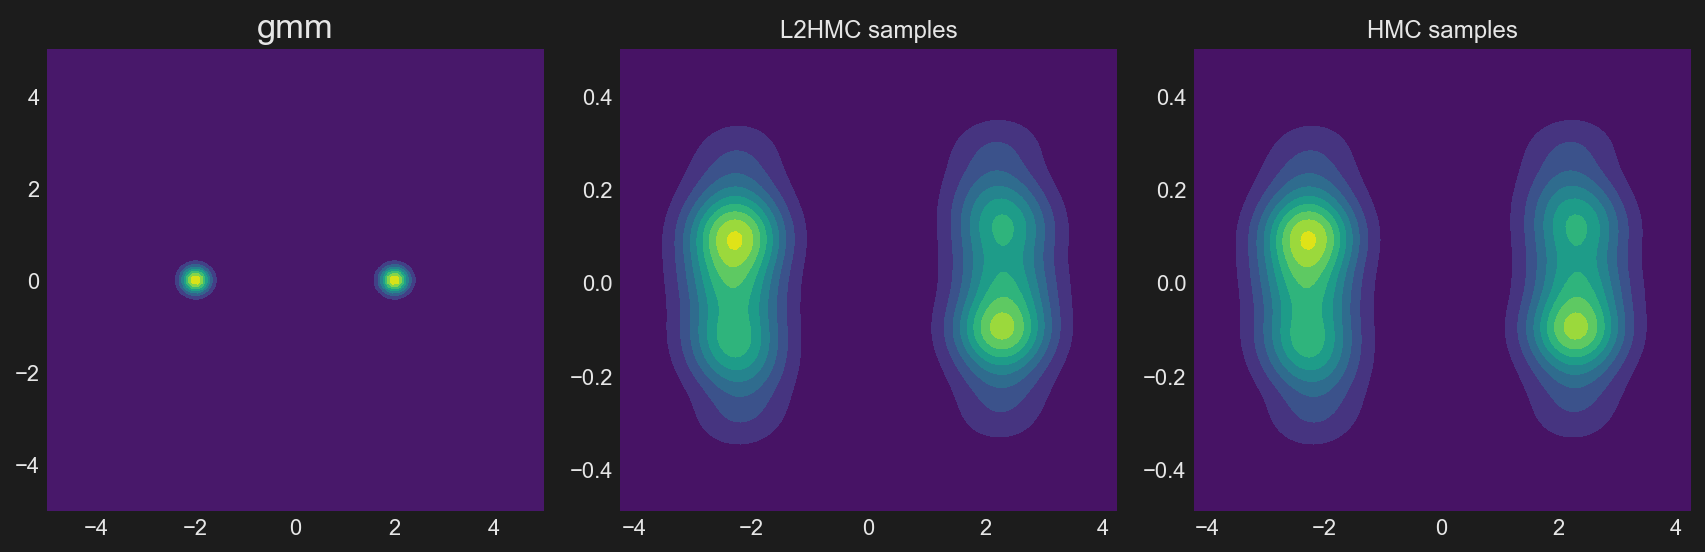

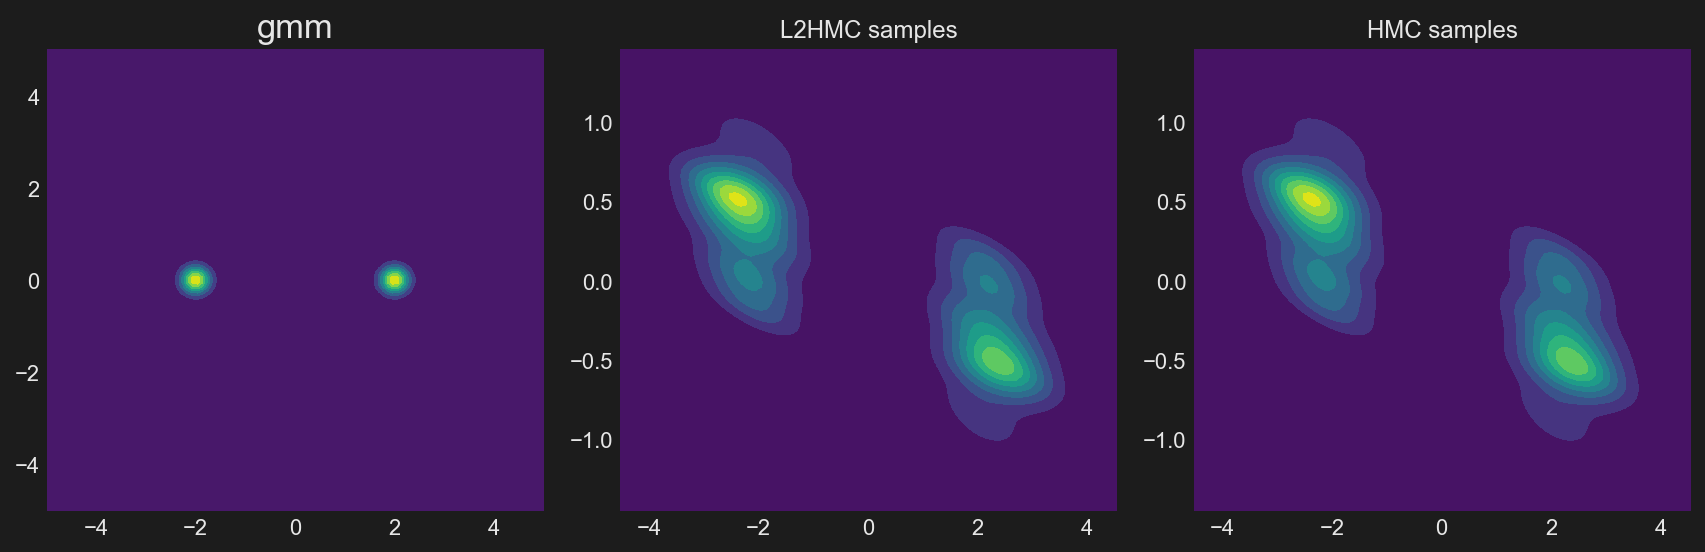

In [26]:
plot_density_estimation(dynamics.potential_fn, x_arr, x_arr,
                        num_plots=2, title=MODEL_TYPE, cmap='viridis')

Text(0.5, 1.0, 'L2HMC samples')

Text(0.5, 1.0, 'HMC samples')

Text(0.5, 1.0, 'L2HMC samples')

Text(0.5, 1.0, 'HMC samples')

Text(0.5, 1.0, 'L2HMC samples')

Text(0.5, 1.0, 'HMC samples')

Text(0.5, 1.0, 'L2HMC samples')

Text(0.5, 1.0, 'HMC samples')

Text(0.5, 1.0, 'L2HMC samples')

Text(0.5, 1.0, 'HMC samples')

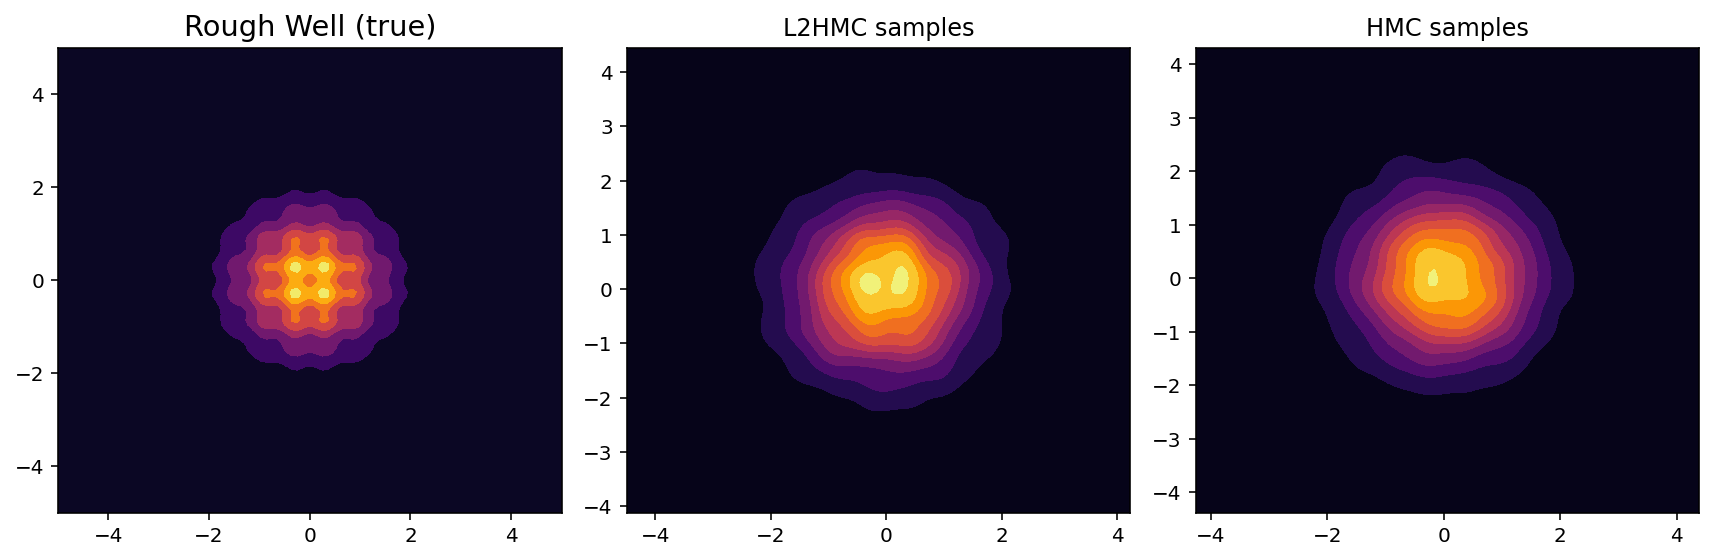

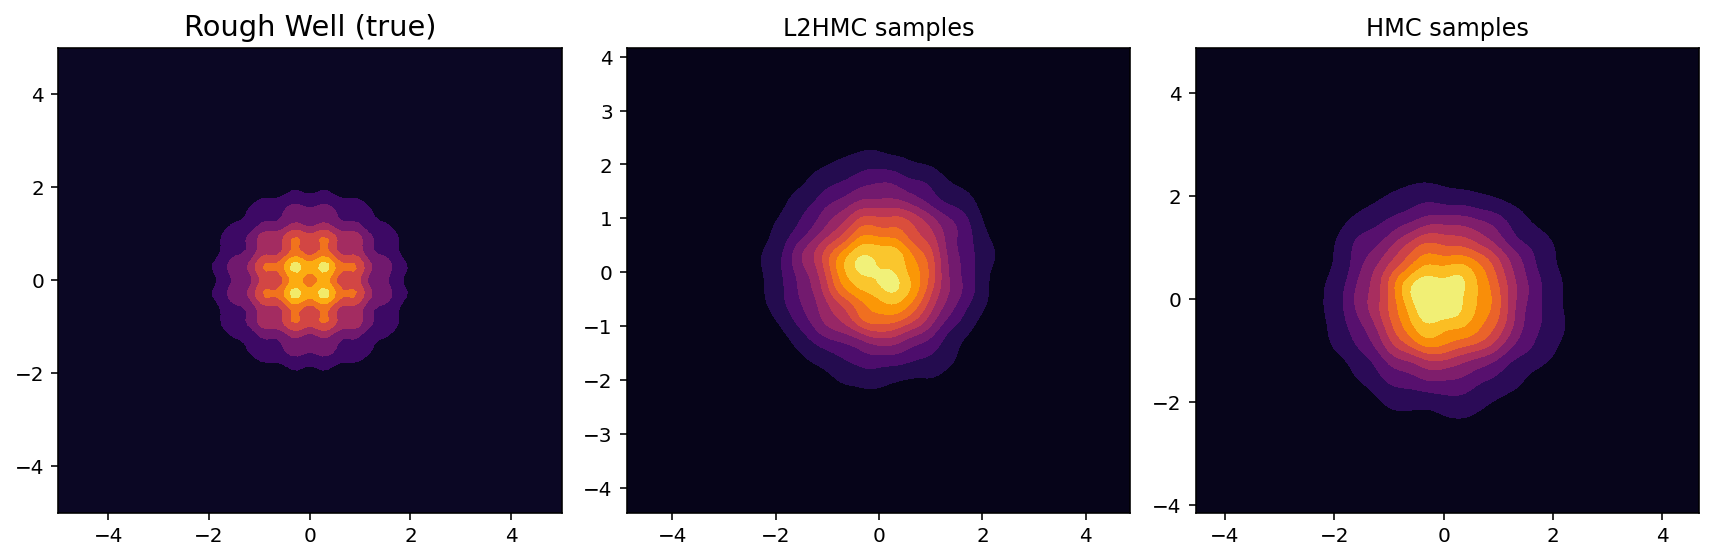

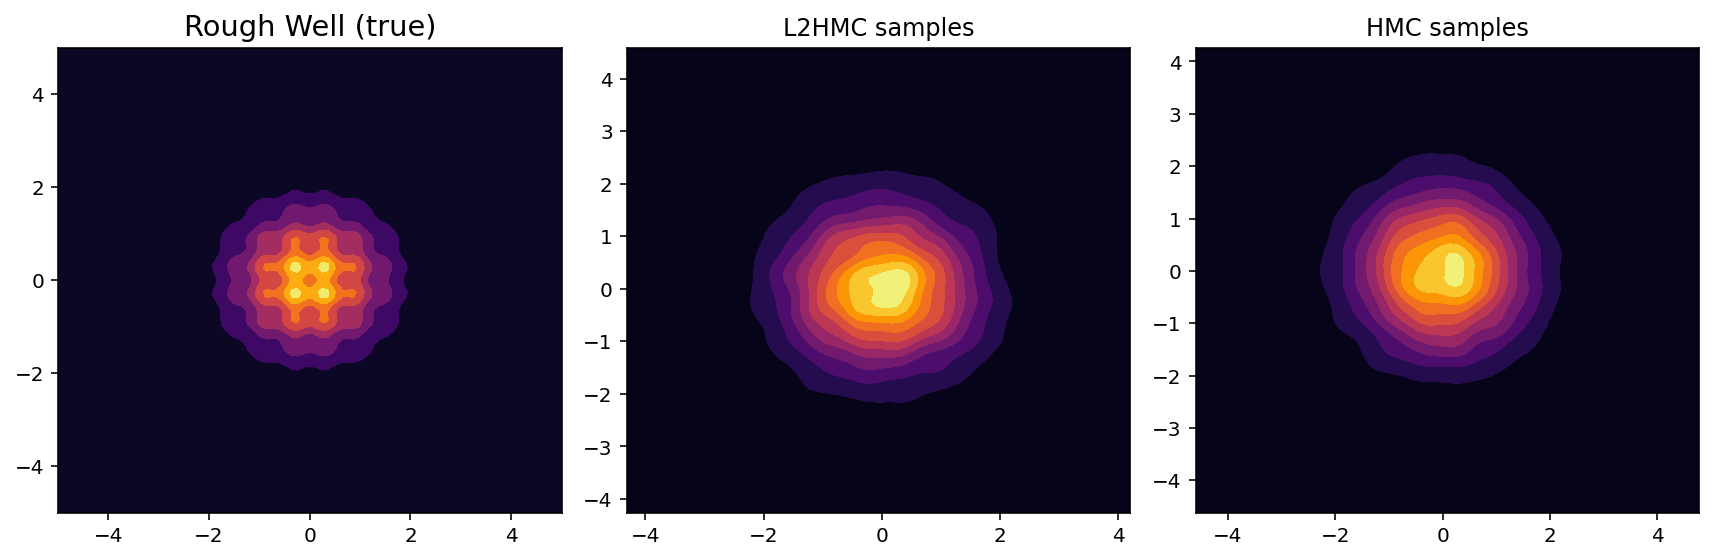

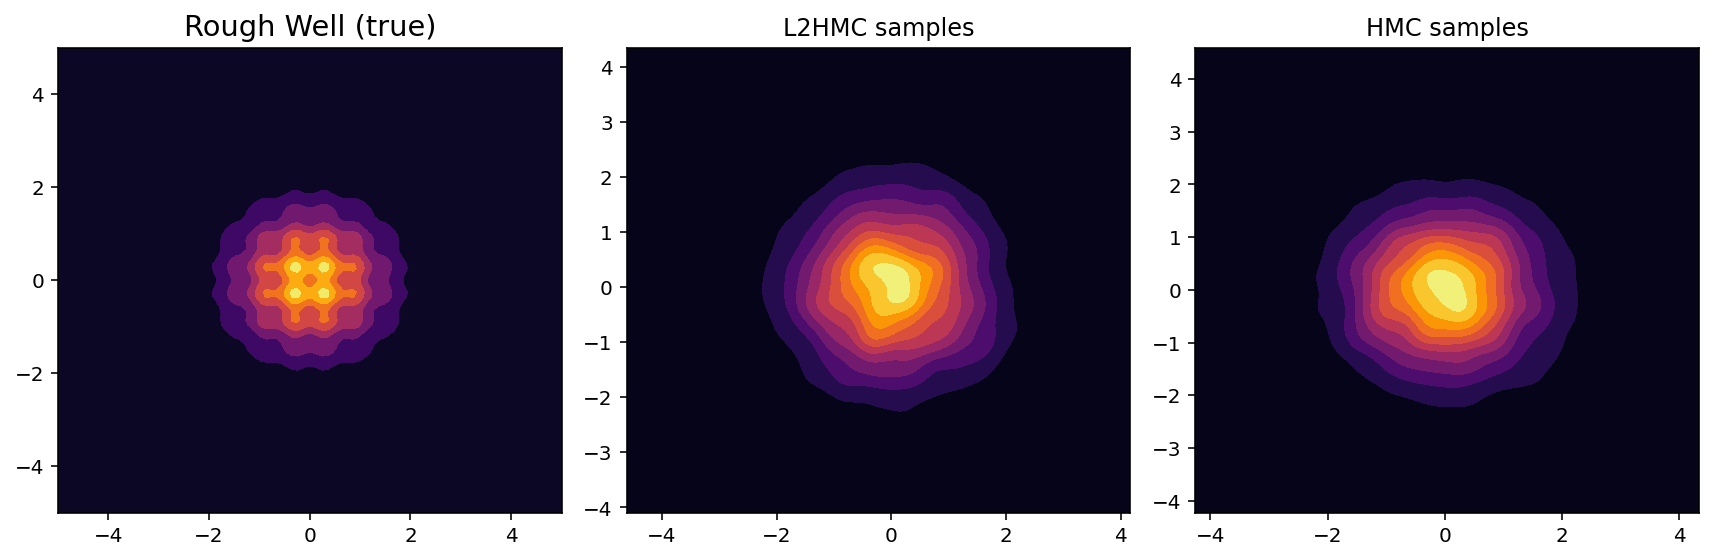

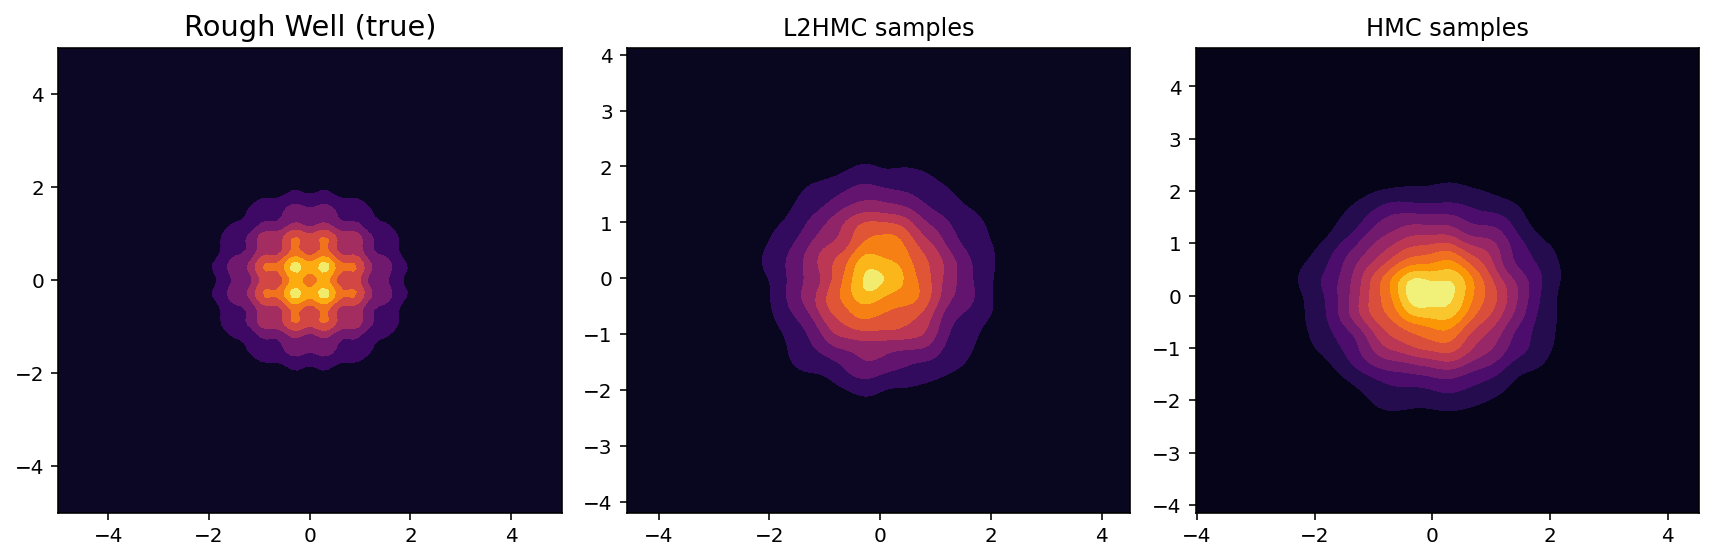

In [77]:
from utils.distributions import contour_potential
xl2hmc = np.array(x_arr)
xhmc = np.array(x_arr_hmc)

for idx in range(5):
    fig, axes = plt.subplots(ncols=3, figsize=(12, 4))
    _ = contour_potential(POTENTIAL_FN, title='Rough Well (true)', ax=axes[0])
    _ = sns.kdeplot(xl2hmc[:, idx, 0], xl2hmc[:, idx, 1],
                    shade=True, cmap='inferno', ax=axes[1])
    _ = sns.kdeplot(xhmc[:, idx, 0], xhmc[:, idx, 1],
                    shade=True, cmap='inferno', ax=axes[2])
    _ = axes[1].set_title('L2HMC samples')
    _ = axes[2].set_title('HMC samples')
    plt.tight_layout()

### L2HMC Samples:

2020-08-31 14:43:10,703:INFO:Creating directory: /Users/saforem2/l2hmc-qcd/two_moons/2020-08-31/figures
Saving figure to: /Users/saforem2/l2hmc-qcd/two_moons/2020-08-31/figures/trained_samples_chain0.png


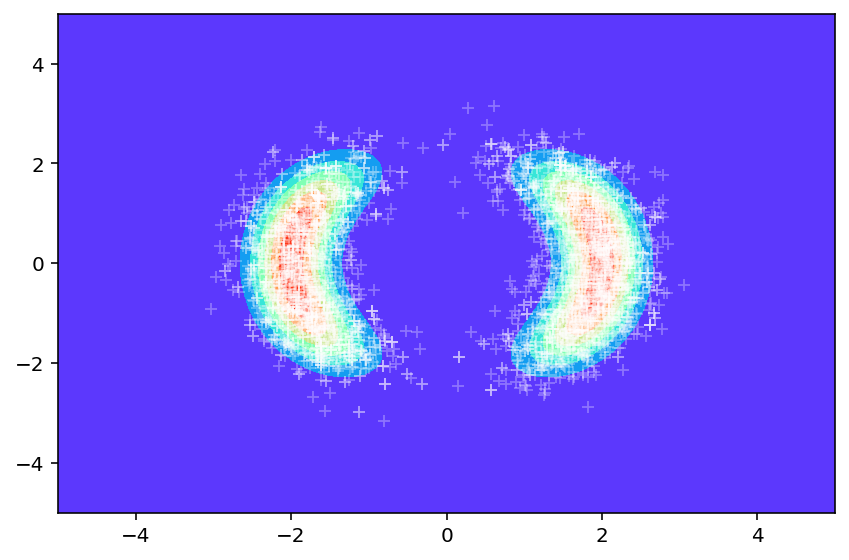

Saving figure to: /Users/saforem2/l2hmc-qcd/two_moons/2020-08-31/figures/trained_samples_chain1.png


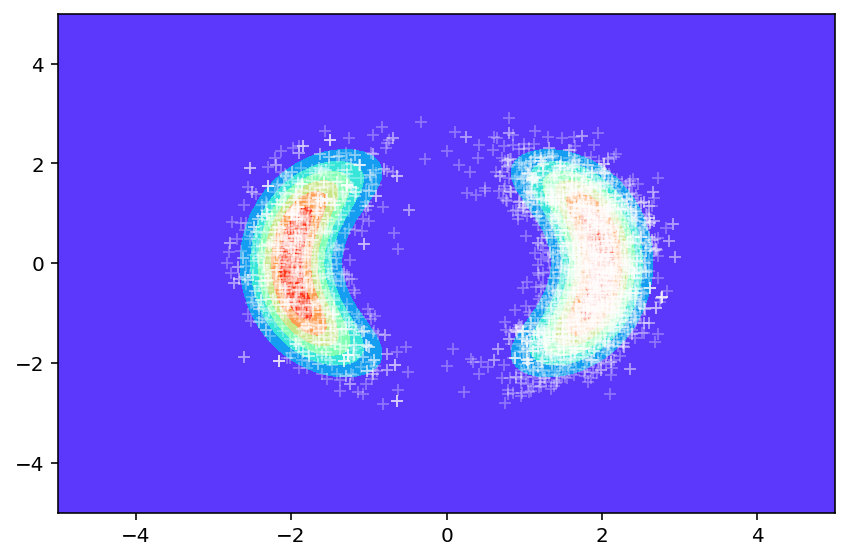

Saving figure to: /Users/saforem2/l2hmc-qcd/two_moons/2020-08-31/figures/trained_samples_chain2.png


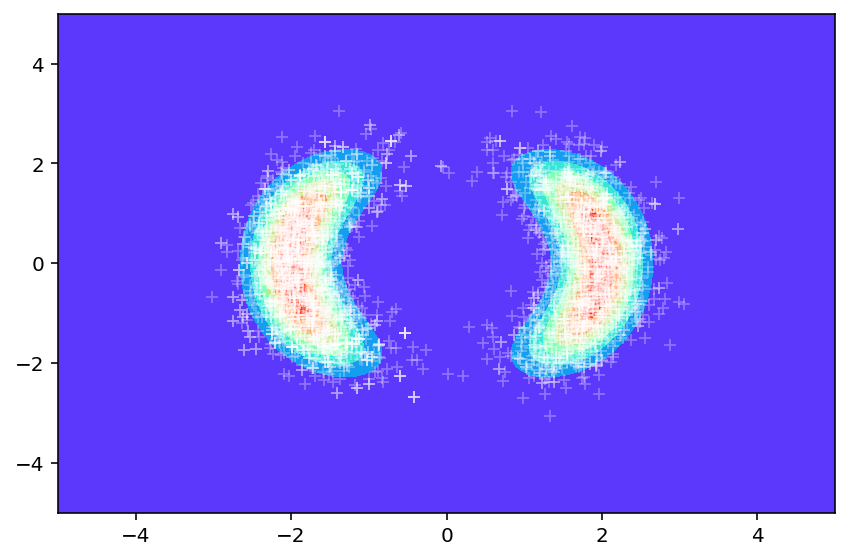

Saving figure to: /Users/saforem2/l2hmc-qcd/two_moons/2020-08-31/figures/trained_samples_chain3.png


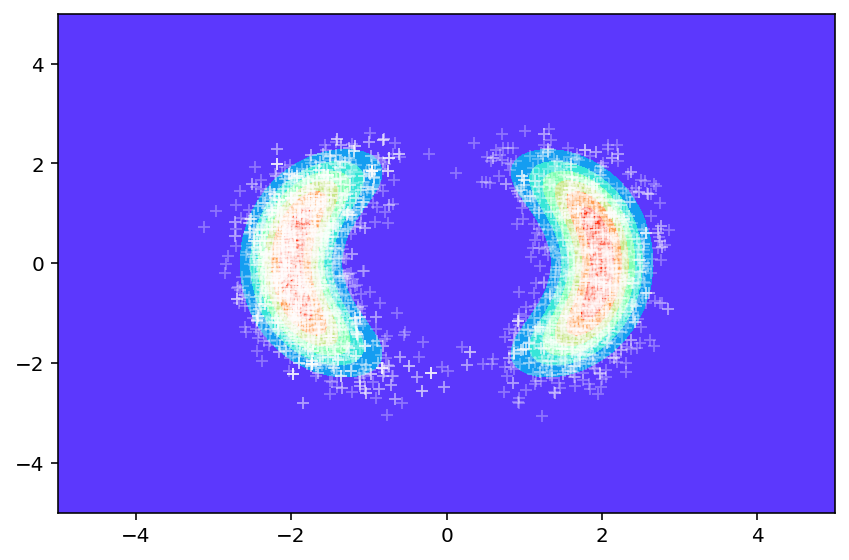

In [19]:
plot_chains(dirs, x_arr, POTENTIAL_FN, label='l2hmc samples', cmap='inferno')

### HMC Samples:

Saving figure to: /Users/saforem2/l2hmc-qcd/two_moons/2020-08-31/figures/trained_samples_chain0.png


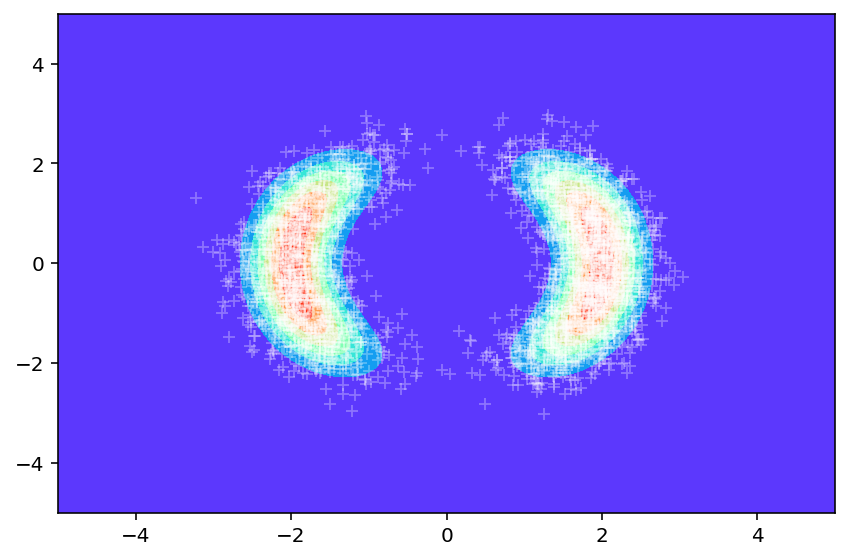

Saving figure to: /Users/saforem2/l2hmc-qcd/two_moons/2020-08-31/figures/trained_samples_chain1.png


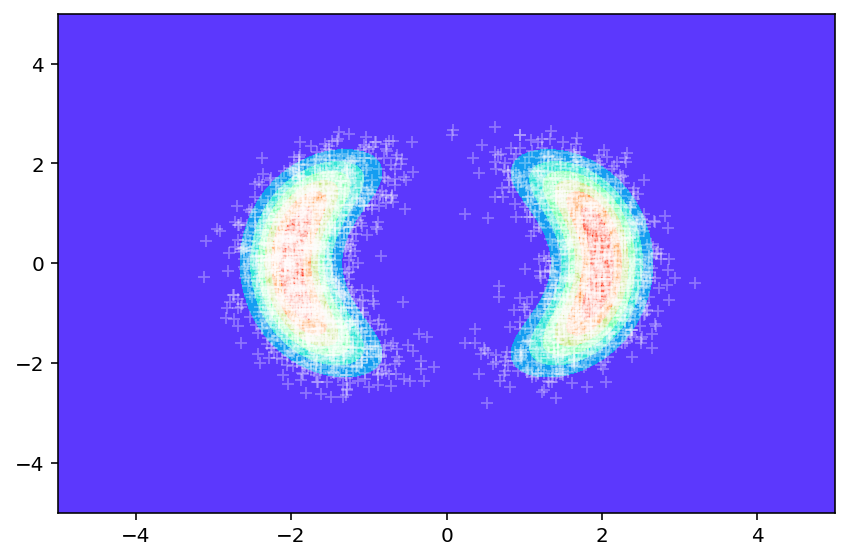

Saving figure to: /Users/saforem2/l2hmc-qcd/two_moons/2020-08-31/figures/trained_samples_chain2.png


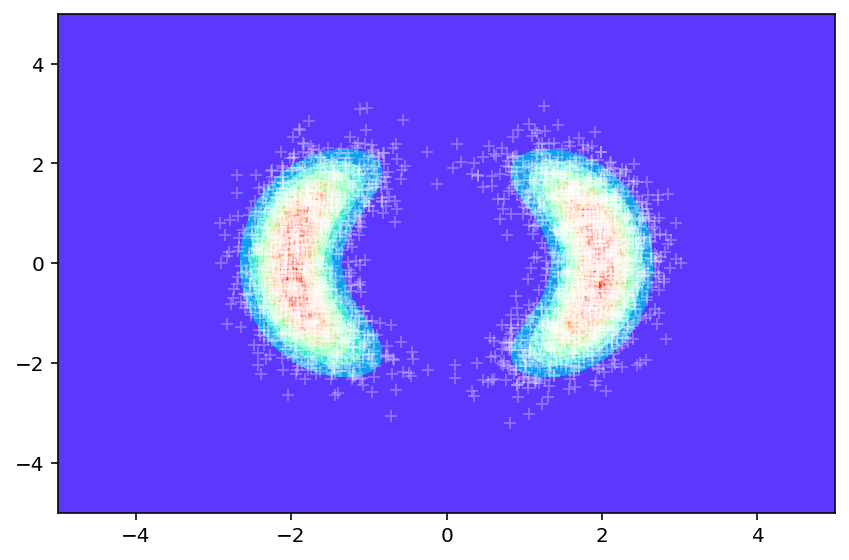

Saving figure to: /Users/saforem2/l2hmc-qcd/two_moons/2020-08-31/figures/trained_samples_chain3.png


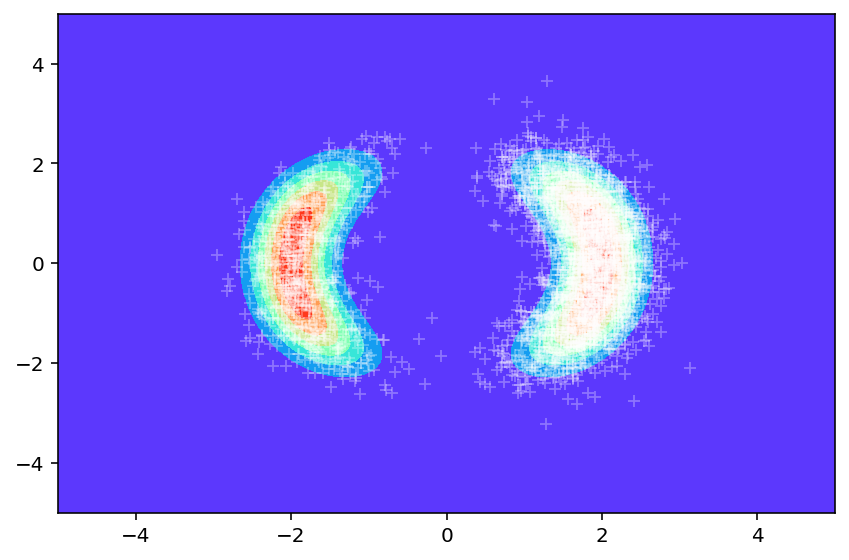

In [20]:
plot_chains(hmc_dirs, x_arr_hmc, POTENTIAL_FN, label='HMC samples', cmap='inferno')